**Preparing environment for Deep Learning**

In [1]:
# Loading google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [3]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

from time import time
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import recall_score
from random import random
from random import seed

# https://github.com/qubvel/segmentation_models
import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing

from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
1.0.1


In [4]:
# https://stackoverflow.com/questions/31984387/command-line-for-7z-to-extract-specific-files-from-specific-folders-inside-an-ar
# extracting raw data
! 7z e '/content/drive/My Drive/severstal_february/archive.zip' -oA1_train       train_images/*.jpg
! 7z e '/content/drive/My Drive/severstal_february/archive.zip' -oA3_trainlabels train.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/severstal_february/                                                     1 file, 1684204253 bytes (1607 MiB)

Extracting archive: /content/drive/My Drive/severstal_february/archive.zip
 22% 4096 Open              --
Path = /content/drive/My Drive/severstal_february/archive.zip
Type = zip
Physical Size = 1684204253

  0%      0% - train_images/0002cc93b.jpg                                   0% 63 - train_images/012d29df4.jpg                                    

In [0]:
train_path = '/content/A1_train/'
train_image_names = os.listdir(train_path)
trainLabels = pd.read_csv('/content/A3_trainlabels/train.csv')

**Generating X_train, X_val and X_test**

In [6]:
train_image_names[:5]

['dbe255803.jpg',
 '02a78fb18.jpg',
 'deb688828.jpg',
 '2e8733afa.jpg',
 '33274bc41.jpg']

In [7]:
tr_img_id = []
tr_cls_id = []
for i in os.listdir(train_path):
    tr_img_id.append(i)
    tr_cls_id.append(1)
    tr_img_id.append(i)
    tr_cls_id.append(2)
    tr_img_id.append(i)
    tr_cls_id.append(3)
    tr_img_id.append(i)
    tr_cls_id.append(4)
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms.head()

ImageId  ClassId
0  dbe255803.jpg        1
1  dbe255803.jpg        2
2  dbe255803.jpg        3
3  dbe255803.jpg        4
4  02a78fb18.jpg        1

In [8]:
train_df = pd.merge(train_img_nms, trainLabels,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  dbe255803.jpg        1                                                   
1  dbe255803.jpg        2                                                   
2  dbe255803.jpg        3  61 8 227 15 315 24 481 30 569 40 734 33 823 55...
3  dbe255803.jpg        4                                                   
4  02a78fb18.jpg        1

In [9]:
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

ImageId  ... Defect_4
0  0002cc93b.jpg  ...         
1  00031f466.jpg  ...         
2  000418bfc.jpg  ...         
3  000789191.jpg  ...         
4  0007a71bf.jpg  ...         

[5 rows x 5 columns]

In [10]:
tmp = []
for i in range(len(train_data)):
    if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_3'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data.head()

ImageId  ... hasDefect_4
0  0002cc93b.jpg  ...           0
1  00031f466.jpg  ...           0
2  000418bfc.jpg  ...           0
3  000789191.jpg  ...           0
4  0007a71bf.jpg  ...           0

[5 rows x 10 columns]

In [11]:
# For stratified sampling, stratified based on minority label priority
# Label 2 : 247
# Label 4 : 801
# Label 1 : 897
# Label 3 : 5150
tmp = []
for i in range(len(train_data)):
    if train_data['hasDefect_2'].iloc[i]==1:
        tmp.append(2)
    elif train_data['hasDefect_4'].iloc[i]==1:
        tmp.append(4)
    elif train_data['hasDefect_1'].iloc[i]==1:
        tmp.append(1)
    elif train_data['hasDefect_3'].iloc[i]==1:
        tmp.append(3)
    else:
        tmp.append(0)
train_data['stratify']=tmp
train_data.head()

ImageId  ... stratify
0  0002cc93b.jpg  ...        1
1  00031f466.jpg  ...        0
2  000418bfc.jpg  ...        0
3  000789191.jpg  ...        0
4  0007a71bf.jpg  ...        3

[5 rows x 11 columns]

**Train. Validation and Test split**

In [12]:
X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(9048, 11) (2263, 11) (1257, 11)


## 3. Exploratory Data Analysis

In [13]:
X_train.head()

ImageId Defect_1 Defect_2  ... hasDefect_3 hasDefect_4  stratify
2695   364e66340.jpg                    ...           0           0         0
9213   bacfd8fc8.jpg                    ...           1           0         3
3911   4f3633a21.jpg                    ...           0           0         0
11245  e47ea998e.jpg                    ...           1           0         3
3564   4803fc0ae.jpg                    ...           1           0         3

[5 rows x 11 columns]

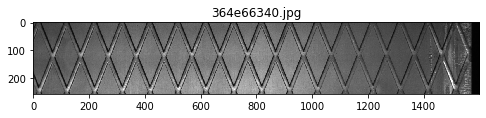

(1600, 256)


In [14]:
# Sample Image
fig, ax = plt.subplots(1,1,figsize=(8, 7))
img = Image.open(str(train_path + X_train.ImageId.iloc[0]))
plt.imshow(img)
ax.set_title(X_train.ImageId.iloc[0])
plt.show()
print(img.size)

**Summary:** The images have 1600x256 pixel resolution

No. of Images in train set:  9048 
 --------------------------------------------------


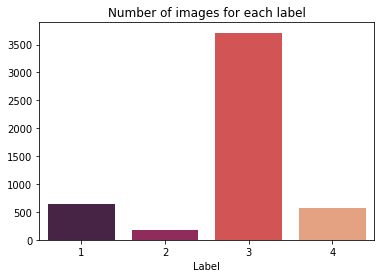

No. of Images having: Label 1 = 645, Label 2 = 178, Label 3 = 3712, Label 4 = 576 
 --------------------------------------------------


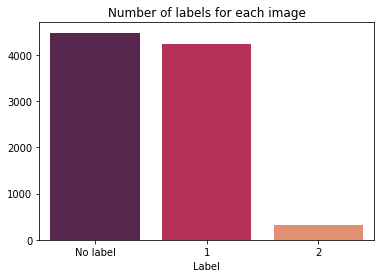

No. of Images with no defects: 4249, with only one label: 4487, with two labels: 312


In [15]:
print("No. of Images in train set: ", X_train.shape[0],'\n','-'*50)

tmp = [sum(X_train['hasDefect_1']==1),
       sum(X_train['hasDefect_2']==1),
       sum(X_train['hasDefect_3']==1),
       sum(X_train['hasDefect_4']==1)]
fig, ax = plt.subplots()
sns.barplot(x=['1','2','3','4'],y=tmp,palette = "rocket")
ax.set_title("Number of images for each label")
ax.set_xlabel("Label")
plt.show()
print("No. of Images having: Label 1 = {}, Label 2 = {}, Label 3 = {}, Label 4 = {}".format(tmp[0],tmp[1],tmp[2],tmp[3]),'\n','-'*50)

tmp = (X_train['hasDefect_1']+X_train['hasDefect_2']+X_train['hasDefect_3']+X_train['hasDefect_4']).value_counts()
fig, ax = plt.subplots()
sns.barplot(x=['No label','1','2'],y=tmp,palette = "rocket")
ax.set_title("Number of labels for each image")
ax.set_xlabel("Label")
plt.show()
print("No. of Images with no defects: {}, with only one label: {}, with two labels: {}".format(tmp[0],tmp[1],tmp[2]))

#### Observation: The dataset is highly imbalanced. This will make predicting minority class (Class 2) difficult. 

Sample images with no defects:


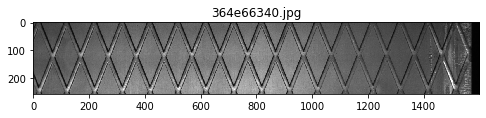

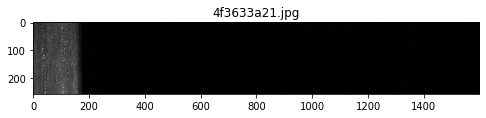

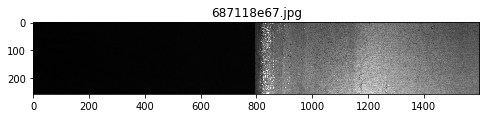

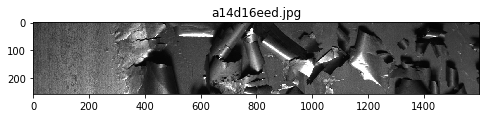

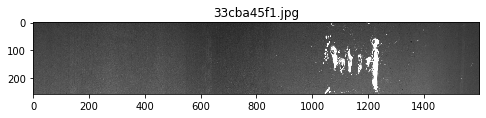

In [16]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with no defects:")
for i in X_train['ImageId'][X_train['hasDefect']==0]:
    if cnt<5:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(train_path + i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

### Observation: 
The surface of the non-defective steel may contain different features or profile. It has to be noted that that presence of defect is limited to the 4 types of defects in this dataset. The steel surface may contain other defects but those should not be detected.

In [0]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    This function is specific to this competition

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This function is specific to this competition
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Sample images with Class 1 defect:


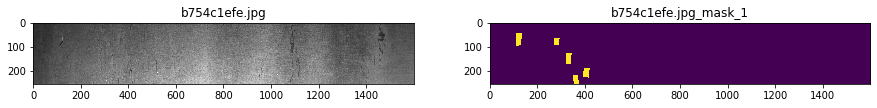

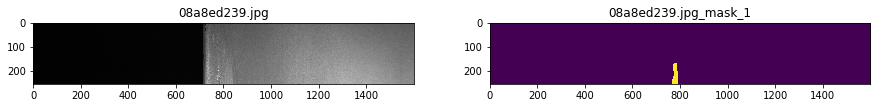

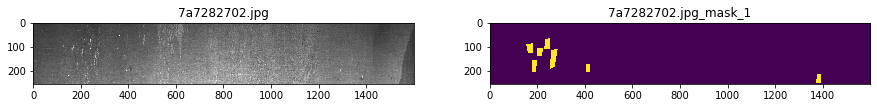

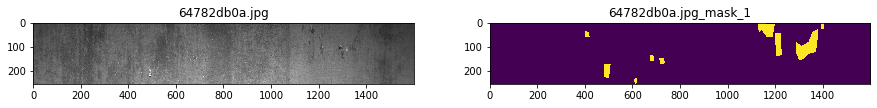

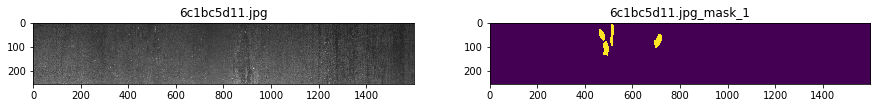

--------------------------------------------------------------------------------
Sample images with Class 2 defect:


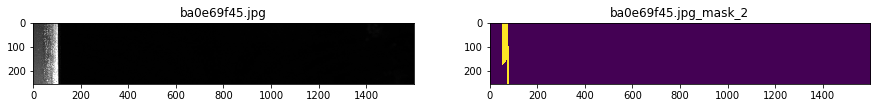

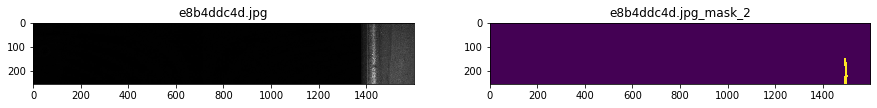

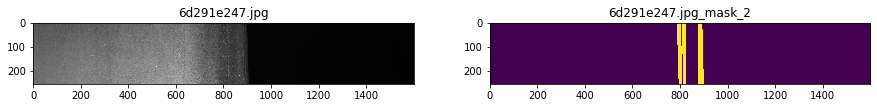

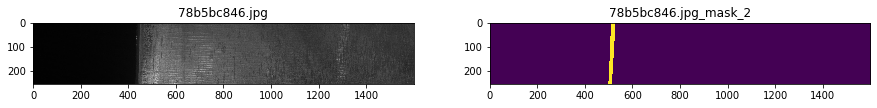

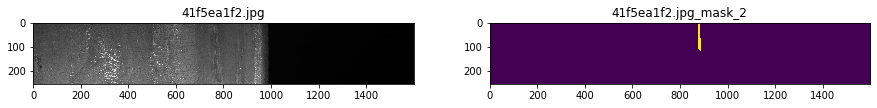

--------------------------------------------------------------------------------
Sample images with Class 3 defect:


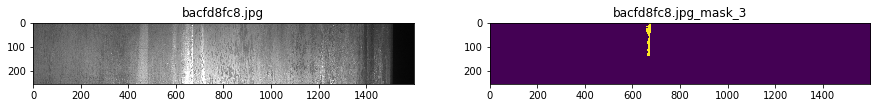

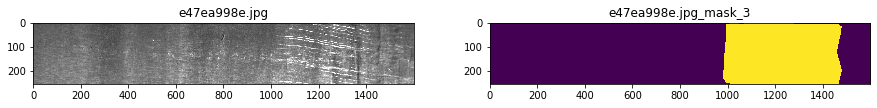

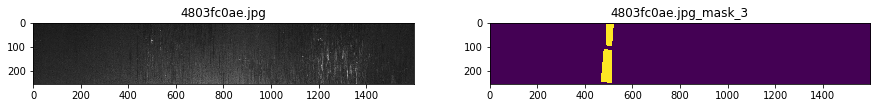

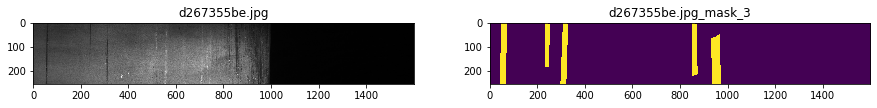

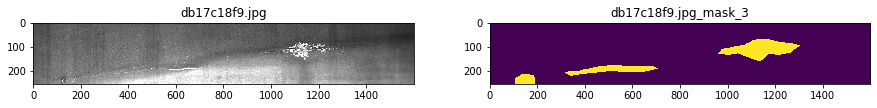

--------------------------------------------------------------------------------
Sample images with Class 4 defect:


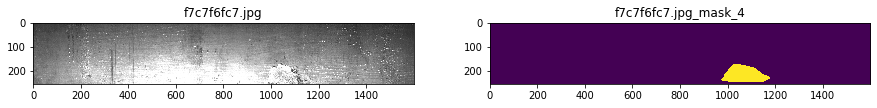

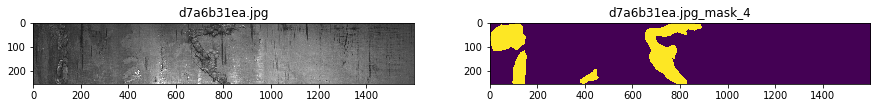

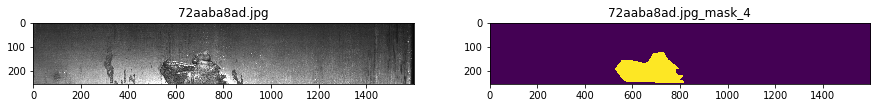

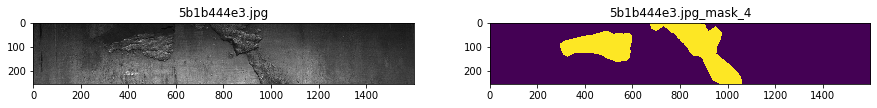

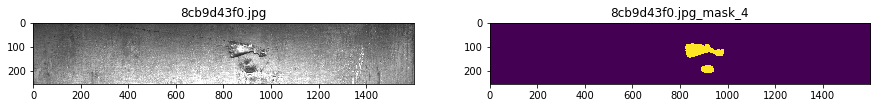

--------------------------------------------------------------------------------


In [18]:
# Visualization: Sample images having defect
for k in [1,2,3,4]:
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in X_train[X_train[f'hasDefect_{k}']==1][['ImageId',f'Defect_{k}']].values:
        if cnt<5:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open(str(train_path + i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*80)

### Observation:
The regional profile on the masks of defect conataining steel surfaces can be seen to be indistinguishable among different classes. Though defect type 1 can be seen to have multiplte small size regions and defect type 4 images have multiple regions of medium size. Defect type 3 images can be seen to also contain multiple regions of medium size. While defect type 2 and type 3 images can be seen to share some regional characteristics. 

#### 'area' as a new feature
Used for thresholding masks after generating predictions

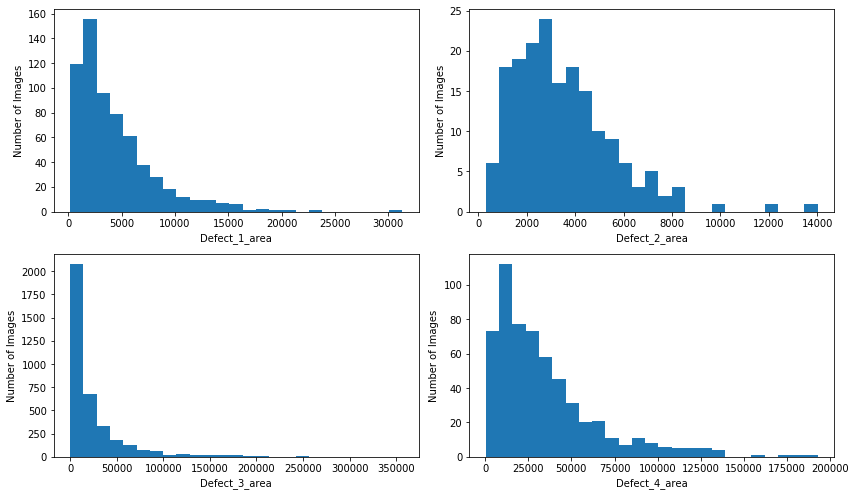

--------------------------------------------------


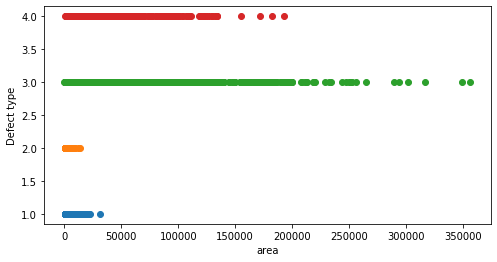

--------------------------------------------------


count          mean           std  ...      50%       75%       max
Defect_1   645.0   4350.477519   3733.559124  ...   3243.0   5773.00   31303.0
Defect_2   178.0   3513.308989   2129.522333  ...   3086.0   4611.75   14023.0
Defect_3  3712.0  25593.268858  37296.152095  ...  12151.0  29399.00  356308.0
Defect_4   576.0  34795.451389  30578.036951  ...  25351.5  45025.25  192780.0

[4 rows x 8 columns]

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,7))

tmp = X_train['Defect_1'][X_train['hasDefect_1']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax1.hist(tmp.values,bins = 25)
ax1.set_xlabel('Defect_1_area')
ax1.set_ylabel('Number of Images')


tmp = X_train['Defect_2'][X_train['hasDefect_2']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax2.hist(tmp.values,bins = 25)
ax2.set_xlabel('Defect_2_area')
ax2.set_ylabel('Number of Images')


tmp = X_train['Defect_3'][X_train['hasDefect_3']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax3.hist(tmp.values,bins = 25)
ax3.set_xlabel('Defect_3_area')
ax3.set_ylabel('Number of Images')


tmp = X_train['Defect_4'][X_train['hasDefect_4']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax4.hist(tmp.values,bins = 25)
ax4.set_xlabel('Defect_4_area')
ax4.set_ylabel('Number of Images')
plt.tight_layout()
plt.show()
print('-'*50)

plt.figure(figsize=(8,4))
for i in [1,2,3,4]:
    tmp = X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
    plt.plot(tmp,np.zeros_like(tmp)+i,'o')
plt.xlabel('area')
plt.ylabel('Defect type')
plt.show()
print('-'*50)

tmp =[]
for i in [1,2,3,4]:

    tmp.append(X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).describe())
area_df = pd.DataFrame(tmp)
area_df.index=['Defect_1','Defect_2','Defect_3','Defect_4']
area_df

### Observation: 
There is considerable overlap in the range of area. Minimum area for each defect type can be seen closer to each other. While the maximum is largely different. We can use the minimum and maximum values of area in training images to threshold test image defect predictions.

In [20]:
# removing areas below 2 percentile and above 98 percentile to threshold area of predicted masks
tmp = []
for i in [1,2,3,4]:
    tmp_1 = X_train[f'Defect_{i}'][X_train[f'hasDefect_{i}']==1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).sort_values().reset_index().drop('index',axis=1)
    tmp.append([tmp_1.iloc[int(0.02*len(tmp_1))].values[0],tmp_1.iloc[-int(0.02*len(tmp_1))].values[0]])
print('Limiting area to above 2 percentile and below 98 percentile values: \n',tmp)

Limiting area to above 2 percentile and below 98 percentile values: 
 [[525, 15305], [751, 9641], [1146, 160085], [2882, 126754]]


In [21]:
area_threshold = pd.DataFrame([[500,15500],[700,10000],[1100,160000],[2800,127000]],
                               columns=['min','max'], index=['defect_1','defect_2','defect_3','defect_4'])
area_threshold # to threshold predictions

min     max
defect_1   500   15500
defect_2   700   10000
defect_3  1100  160000
defect_4  2800  127000

### Summary:
Based on range of area for each defect, we will threshold predictions to filter outliers. For e.g. some predicted masks have only 4 pixels that have value 1. Such an image will reduce the performance of the model on the final metric.

## EDA conclusion: 

a) The dataset is imbalanced thus we will use stratified sampling for splitting the dataset into train and validation datasets. <br> 

b) This is a multi-label image segmentation problem. As there are around 50% of images with no defects, it is equally important to identify images with no defects. <br> 

c) Based on area thresholds from 'test_thresolds' dataframe and class probability thresholds (which are to be determined after predictions from neural networks), we will ensure that number of predicted images per defect will be closer to the values in 'count' column. <br>

d) Procedure:
  1. We will have a binary classification model to filter images with defects from no defect images. 
  2. A 4-label classification model to predict probablities of images beloning to each class.
  3. 4 segmentation models for four different classes to generate masks for each test image.
  4. Convert masks to EncodedPixels and filter them as per classification probabilities.

e) We are generating a new solution to the business problem with available libraries: tensorflow, keras and segmentation_models. 

### Model architecture:
<img src='model_arch_new.jpg' width=1000px align=left>

Blue dots in the Architecture image indicates that an input is being given at that level, while black dot near "Apply threholds" correspond to the application of thresholds at the output of predicted masks. At the threshold application level images are filtered based on Defect presence probability, Defect type belongingness and area of the defect.

## 4. Data preparation and Model Building

In [0]:
train_segmentation = True
train_classification_binary = True
train_classification_multi = True
epochs = 30

In [0]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom metrics, https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch
# For clasification
def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'dice_coef':dice_coef,
    'f1_score_m':f1_score_m,
    'dice_loss':sm.losses.dice_loss
}

### 4.1 Binary Classification

- Train and predict the probability of presence of defects in images .

### 4.1.1 Data Preparation

In [24]:
X_train_binary = X_train[['ImageId','hasDefect']]
X_val_binary = X_val[['ImageId','hasDefect']]
X_test_binary = X_test[['ImageId','hasDefect']]

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_binary.shape, X_val_binary.shape, X_test_binary.shape)

(9048, 11) (2263, 11) (1257, 11)
(9048, 2) (2263, 2) (1257, 2)


In [25]:
# https://keras.io/preprocessing/image/
# https://stackoverflow.com/questions/52754492/write-custom-data-generator-for-keras

# DataGenerator for the binary classification model with image augmentations

train_DataGenerator_1 = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                           width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

test_DataGenerator_1 = ImageDataGenerator(rescale=1./255)

train_generator = train_DataGenerator_1.flow_from_dataframe(
        dataframe=X_train_binary.astype(str),
        directory=train_path,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(256,512),
        batch_size=16,
        class_mode='binary')

validation_generator = test_DataGenerator_1.flow_from_dataframe(
        dataframe=X_val_binary.astype(str),
        directory=train_path,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(256,512),
        batch_size=16,
        class_mode='binary')

Found 9048 validated image filenames belonging to 2 classes.
Found 2263 validated image filenames belonging to 2 classes.


### 4.1.2 Binary Classification Model Definition

In [26]:
# https://www.youtube.com/watch?v=2U6Jl7oqRkM
# Using a pretrained model from keras for classification: 
# Selecting Xception pretrained model
# https://keras.io/applications/

base_model = keras.applications.xception.Xception(include_top = False, input_shape = (256,512,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# and the prediction layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()













83689472/83683744 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________

### 4.1.3 Binary Classification Model Training

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
if train_classification_binary==True:
    logdir = "/content/drive/My Drive/severstal_february/severstal_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_binary_01_02_2020'

    # https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
    file_writer = tf.summary.FileWriter(logdir + "/metrics")
    tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
    # https://keras.io/callbacks/

    mc = ModelCheckpoint('/content/drive/My Drive/severstal_february/severstal_model/severstal_binary_01_02_2020.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)
    history = model.fit_generator(train_generator, validation_data = validation_generator, epochs = epochs, verbose=1, callbacks = [mc,tensorboard])
    file_writer.close()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30
566/566 [==============================] - 349s 616ms/step - loss: 0.5951 - acc: 0.7096 - f1_score_m: 0.7229 - precision_m: 0.7230 - recall_m: 0.7638 - val_loss: 0.9190 - val_acc: 0.6270 - val_f1_score_m: 0.4456 - val_precision_m: 0.9076 - val_recall_m: 0.3104

Epoch 00001: val_f1_score_m improved from -inf to 0.44558, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_binary_01_02_2020.h5

Epoch 2/30
566/566 [==============================] - 336s 593ms/step - loss: 0.4048 - acc: 0.8166 - f1_score_m: 0.8180 - precision_m: 0.8544 - recall_m: 0.8115 - val_loss: 0.7267 - val_acc: 0.7198 - val_f1_score_m: 0.6341 - val_precision_m: 0.9117 - val_recall_m: 0.5071

Epoch 00002: val_f1_score_m improved from 0.44558 to 0.63412, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_binary_01_02_2020.h5
Epoch 3/30
566/566 [=

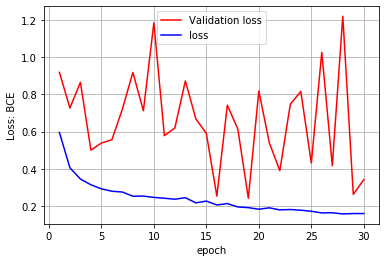

In [28]:
vy = history.history['val_loss']
ty = history.history['loss']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation loss")
ax.plot(x,ty,'b',label = "loss")
ax.set_xlabel('epoch')
ax.set_ylabel('Loss: BCE')
plt.legend()
plt.grid()
plt.show()

Tensorboard visualization (similar to above plot)

<img src='./binary_tensorboard/train_loss.jpg' width=600px align = left> 

**Summary:** Train loss reduction is smooth.

<img src='./binary_tensorboard/val_loss.jpg' width=600px align = left>

**Summary:** Binary cross entropy loss of the model can be seen to have large variations on validation set. This implies that the model is having tough time generalizing on unseen dataset.

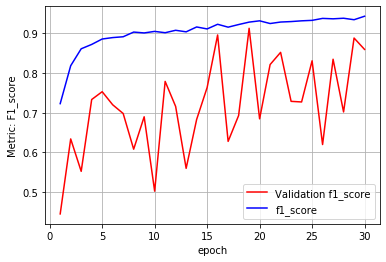

In [29]:
vy = history.history['val_f1_score_m']
ty = history.history['f1_score_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation f1_score")
ax.plot(x,ty,'b',label = "f1_score") # Train set
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: F1_score')
plt.legend()
plt.grid()
plt.show()

<img src='./binary_tensorboard/train_f1.jpg' width=600px align = left>

<img src='./binary_tensorboard/val_f1.jpg' width=600px align = left>

**Summary:** Similar to BCE loss, f1_score on validation set can be seen to vary a lot this implies that the training dataset is insufficient.

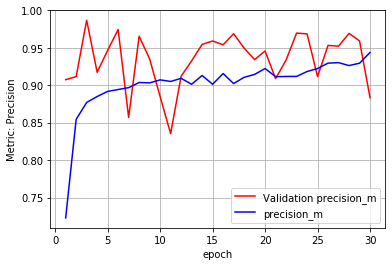

In [30]:
vy = history.history['val_precision_m']
ty = history.history['precision_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation precision_m")
ax.plot(x,ty,'b',label = "precision_m") # Train set
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: Precision')
plt.legend()
plt.grid()
plt.show()

**Summary:** Precision can be seen to improve smoothly at every epoch. Precision tells how many predicted positives are actually positive. The behavior implies that the performance of the model on successfully predicting negatives is good. High precision implies less false positives.

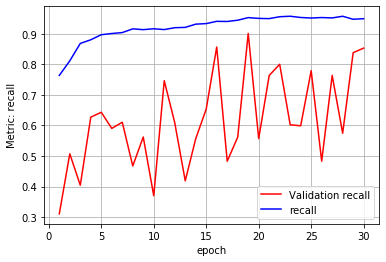

In [31]:
vy = history.history['val_recall_m']
ty = history.history['recall_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation recall")
ax.plot(x,ty,'b',label = "recall")
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: recall')
plt.legend()
plt.grid()
plt.show()

**Summary:** Recall can be seen to vary largely at every epoch. Recall tells how many positives are predicted out of total actual positives. The behavior implies that the performance of the model on successfully predicting positives is poor. High recall implies less false negatives.

**F1_score metric Justification:** For this image segmentation task, it is very important to achieve a high precision high recall model. Thus, f1_score is a suitable metric for the classification models. The classification model is monitored for high f1_score for saving model weights.

### 4.1.4 Binary Classification Evaluation

In [0]:
# Loading best model trained on binary classification
model = load_model('/content/drive/My Drive/severstal_february/severstal_model/severstal_binary_01_02_2020.h5', custom_objects=dependencies)

In [33]:
# During evaluation image augmentations are not to be included thus the DataGenerators are redefined.

train_generator = test_DataGenerator_1.flow_from_dataframe(dataframe=X_train_binary.astype(str),
                                                           directory=train_path,
                                                           x_col="ImageId",
                                                           y_col="hasDefect",
                                                           target_size=(256,512),
                                                           batch_size=16,
                                                           class_mode='binary',
                                                           shuffle=False)

validation_generator = test_DataGenerator_1.flow_from_dataframe(dataframe=X_val_binary.astype(str),
                                                                directory=train_path,
                                                                x_col="ImageId",
                                                                y_col="hasDefect",
                                                                target_size=(256,512),
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                shuffle=False)

test_generator = test_DataGenerator_1.flow_from_dataframe(dataframe=X_test_binary.astype(str),
                                                                directory=train_path,
                                                                x_col="ImageId",
                                                                y_col="hasDefect",
                                                                target_size=(256,512),
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                shuffle=False)

Found 9048 validated image filenames belonging to 2 classes.
Found 2263 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.


In [34]:
train_evaluate = model.evaluate(train_generator,verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

566/566 [==============================] - 76s 134ms/step
Train set evaluation score:


binary_crossentropy  0.202241
acc                  0.923630
f1_score_m           0.921999
precision_m          0.949316
recall_m             0.905966

In [35]:
val_evaluate = model.evaluate(validation_generator,verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(val_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

142/142 [==============================] - 19s 131ms/step
Validation set evaluation score:


binary_crossentropy  0.240638
acc                  0.912064
f1_score_m           0.912423
precision_m          0.937087
recall_m             0.898664

In [36]:
test_evaluate = model.evaluate(test_generator,verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

79/79 [==============================] - 11s 139ms/step
Test set evaluation score:


binary_crossentropy  0.194755
acc                  0.926810
f1_score_m           0.921435
precision_m          0.955327
recall_m             0.902135

**Summary:** The model is having good performance on train, validation and test dataset. The values of loss and metrics can be seen to be similar in these datasets. This tells that the model is not overfitting on dataset. The f1_score of 0.921 on validation dataset is acceptable.

## 4.2 Multi-label classification

### 4.2.1 Data Preparation

In [37]:
X_train_multi = X_train[['ImageId','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']][X_train['hasDefect']==1]
X_val_multi = X_val[['ImageId','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']][X_val['hasDefect']==1]
X_test_multi = X_test[['ImageId','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']][X_test['hasDefect']==1]

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_multi.shape, X_val_multi.shape, X_test_multi.shape)

(9048, 11) (2263, 11) (1257, 11)
(4799, 5) (1200, 5) (667, 5)


In [38]:
# https://keras.io/preprocessing/image/
# https://stackoverflow.com/questions/52754492/write-custom-data-generator-for-keras

# DataGenerator for the multi label classification model with image augmentations
train_DataGenerator_2 = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                           width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)


train_generator = train_DataGenerator_2.flow_from_dataframe(
        dataframe=X_train_multi.astype(str),
        directory='/content/A1_train',
        x_col="ImageId",
        y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
        target_size=(256,512),
        batch_size=16,
        class_mode='other')


test_DataGenerator_2 = ImageDataGenerator(rescale=1./255)
validation_generator = test_DataGenerator_2.flow_from_dataframe(
        dataframe=X_val_multi.astype(str),
        directory='/content/A1_train',
        x_col="ImageId",
        y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
        target_size=(256,512),
        batch_size=16,
        class_mode='other')

Found 4799 validated image filenames.
Found 1200 validated image filenames.


### 4.2.2 Multi-Label Classification Model Definition

In [39]:
# Using a pretrained model from keras for classification: 
# Selecting Xception pretrained model
# https://keras.io/applications/

base_model = keras.applications.xception.Xception(include_top = False, input_shape = (256,512,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add fully-connected layers
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# and the prediction layer
predictions = Dense(4, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 255, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### 4.2.3 Multi-label Classification Model Training

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
if train_classification_multi==True:
    logdir = "/content/drive/My Drive/severstal_february/severstal_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_multi_Defect_01_02_2020'
    # https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
    file_writer = tf.summary.FileWriter(logdir + "/metrics")
    tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
    # https://keras.io/callbacks/
    mc = ModelCheckpoint('/content/drive/My Drive/severstal_february/severstal_model/severstal_multi_01_02_2020.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)
    history = model.fit_generator(train_generator, validation_data = validation_generator, epochs = epochs, verbose=1, callbacks = [mc,tensorboard])
    file_writer.close()

Epoch 1/30
300/300 [==============================] - 186s 621ms/step - loss: 0.3444 - acc: 0.8638 - f1_score_m: 0.7395 - precision_m: 0.7602 - recall_m: 0.7248 - val_loss: 0.4560 - val_acc: 0.8581 - val_f1_score_m: 0.7558 - val_precision_m: 0.6973 - val_recall_m: 0.8291

Epoch 00001: val_f1_score_m improved from -inf to 0.75576, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_multi_01_02_2020.h5
Epoch 2/30
300/300 [==============================] - 178s 592ms/step - loss: 0.2930 - acc: 0.8772 - f1_score_m: 0.7650 - precision_m: 0.7799 - recall_m: 0.7545 - val_loss: 0.4117 - val_acc: 0.8740 - val_f1_score_m: 0.7490 - val_precision_m: 0.7860 - val_recall_m: 0.7176

Epoch 00002: val_f1_score_m did not improve from 0.75576
Epoch 3/30
300/300 [==============================] - 178s 593ms/step - loss: 0.2438 - acc: 0.8981 - f1_score_m: 0.8049 - precision_m: 0.8207 - recall_m: 0.7934 - val_loss: 0.8565 - val_acc: 0.7925 - val_f1_score_m: 0.5950 - val_prec

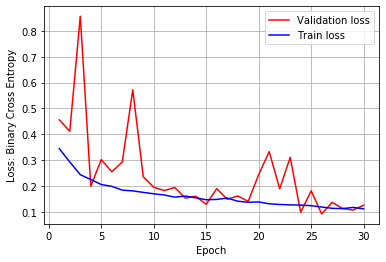

In [41]:
# plot on "loss" vs epoch
vy = history.history['val_loss']
ty = history.history['loss']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation loss")
ax.plot(x,ty,'b',label = "Train loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss: Binary Cross Entropy')
plt.legend()
plt.grid()
plt.show()

<img src='./multi_tensorboard/train_loss.jpg' width=600px align = left>

<img src='./multi_tensorboard/val_loss.jpg' width=600px align = left>

**Summary:** Binary cross entropy loss of the model can be seen to reduce smoothly on validation set. 

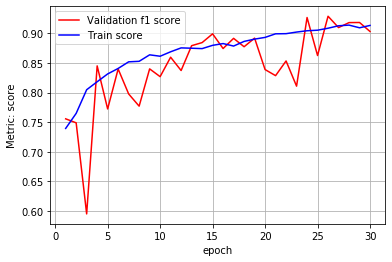

In [42]:
# Plot on f1_score vs epoch
vy = history.history['val_f1_score_m']
ty = history.history['f1_score_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation f1 score")
ax.plot(x,ty,'b',label = "Train score")
ax.set_xlabel('epoch')
ax.set_ylabel('Metric: score')
plt.legend()
plt.grid()
plt.show()

**Summary:** Similar to BCE loss, f1_score can be seen to smoothly increase on validation set.

### 4.2.4 Multi-label Classification Evaluation

In [0]:
# loading best saved multi_label classification model
model = load_model('/content/drive/My Drive/severstal_february/severstal_model/severstal_multi_01_02_2020.h5', custom_objects=dependencies)

In [44]:
# During evaluation we do not require image augmentations
train_generator = test_DataGenerator_2.flow_from_dataframe(dataframe=X_train_multi.astype(str),
                                                           directory=train_path,
                                                           x_col="ImageId",
                                                           y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                                           target_size=(256,512),
                                                           batch_size=16,
                                                           class_mode='other',
                                                           shuffle=False)

validation_generator = test_DataGenerator_2.flow_from_dataframe(dataframe=X_val_multi.astype(str),
                                                                directory=train_path,
                                                                x_col="ImageId",
                                                                y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                                                target_size=(256,512),
                                                                batch_size=16,
                                                                class_mode='other',
                                                                shuffle=False)

test_generator = test_DataGenerator_2.flow_from_dataframe(dataframe=X_test_multi.astype(str),
                                                                directory=train_path,
                                                                x_col="ImageId",
                                                                y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                                                target_size=(256,512),
                                                                batch_size=16,
                                                                class_mode='other',
                                                                shuffle=False)


Found 4799 validated image filenames.
Found 1200 validated image filenames.
Found 667 validated image filenames.


In [45]:
train_evaluate = model.evaluate(train_generator,verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

300/300 [==============================] - 41s 138ms/step
Train set evaluation score:


binary_crossentropy  0.081054
acc                  0.968118
f1_score_m           0.940510
precision_m          0.945815
recall_m             0.937232

In [46]:
val_evaluate = model.evaluate(validation_generator,verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(val_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

75/75 [==============================] - 10s 129ms/step
Validation set evaluation score:


binary_crossentropy  0.092119
acc                  0.962500
f1_score_m           0.929417
precision_m          0.929264
recall_m             0.931588

In [47]:
test_evaluate = model.evaluate(test_generator,verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

42/42 [==============================] - 6s 131ms/step
Test set evaluation score:


binary_crossentropy  0.094178
acc                  0.965517
f1_score_m           0.936398
precision_m          0.941134
recall_m             0.933854

**Summary:** The multi-label classification model is generalizing well on unseen data (the values of evaluation on test set and validation set are closer to train set).

## 4.3 Image segmentation

### 4.3.1 Data preparation

In [48]:
# Dividing the datasets w.r.t. Class Label (defect type)
train_data_1 = X_train[X_train['hasDefect_1']==1][['ImageId','Defect_1']]
train_data_2 = X_train[X_train['hasDefect_2']==1][['ImageId','Defect_2']]
train_data_3 = X_train[X_train['hasDefect_3']==1][['ImageId','Defect_3']]
train_data_4 = X_train[X_train['hasDefect_4']==1][['ImageId','Defect_4']]

val_data_1 = X_val[X_val['hasDefect_1']==1][['ImageId','Defect_1']]
val_data_2 = X_val[X_val['hasDefect_2']==1][['ImageId','Defect_2']]
val_data_3 = X_val[X_val['hasDefect_3']==1][['ImageId','Defect_3']]
val_data_4 = X_val[X_val['hasDefect_4']==1][['ImageId','Defect_4']]

test_data_1 = X_test[X_test['hasDefect_1']==1][['ImageId','Defect_1']]
test_data_2 = X_test[X_test['hasDefect_2']==1][['ImageId','Defect_2']]
test_data_3 = X_test[X_test['hasDefect_3']==1][['ImageId','Defect_3']]
test_data_4 = X_test[X_test['hasDefect_4']==1][['ImageId','Defect_4']]

train_data_1.columns = train_data_2.columns = train_data_3.columns = train_data_4.columns = ['ImageId','EncodedPixels']
val_data_1.columns = val_data_2.columns = val_data_3.columns = val_data_4.columns = ['ImageId','EncodedPixels']
test_data_1.columns = test_data_2.columns = test_data_3.columns = test_data_4.columns = ['ImageId','EncodedPixels']

print(test_data_1.head())
print('-'*50)
print(X_train.shape, X_val.shape, X_test.shape)
print(train_data_1.shape,val_data_1.shape,test_data_1.shape)
print(train_data_2.shape,val_data_2.shape,test_data_2.shape)
print(train_data_3.shape,val_data_3.shape,test_data_3.shape)
print(train_data_4.shape,val_data_4.shape,test_data_4.shape)

            ImageId                                      EncodedPixels
9264  bbd3d337f.jpg  62834 2 63086 6 63338 10 63590 14 63842 18 640...
3304  42b398dcf.jpg  348419 13 348675 39 348931 65 349187 91 349443...
5724  73afc8798.jpg  225900 37 226023 26 226110 107 226241 64 22632...
2389  301601620.jpg  100643 3 100897 7 101151 11 101404 17 101658 2...
3353  43c6a30fa.jpg  106117 4 106371 12 106625 20 106879 25 107133 ...
--------------------------------------------------
(9048, 11) (2263, 11) (1257, 11)
(645, 2) (161, 2) (91, 2)
(178, 2) (44, 2) (25, 2)
(3712, 2) (914, 2) (524, 2)
(576, 2) (144, 2) (81, 2)


In [0]:
# code reference, https://www.kaggle.com/cdeotte/keras-unet-with-eda# https://www.kaggle.com/cdeotte/keras-unet-with-eda
def rle2maskResize(rle):
    '''
    Generates masks for each image taking RLE as input
    Converts run length encoding to an image of shape defined uniform throughout segmentation models: 256x800
    Takes EncodedPixels as input, converts into 256x1600 mask and returns a resized mask image of size 256x800
    '''
    if (pd.isnull(rle))|(rle==''): # If the EncodedPixels string is empty an empty mask is returned
        return np.zeros((256,800) ,dtype=np.uint8)

    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1 # The pixel array definition starts from 1 while array starts from 0
    lengths = array[1::2]  # The second element of EncodedPixels is the length denoting number of pixels in successive that are active (value = 1)
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1 # Making 
    
    return mask.reshape((height,width),order='F')[::,::2]

In [0]:
# https://www.kaggle.com/cdeotte/keras-unet-with-eda# https://www.kaggle.com/cdeotte/keras-unet-with-eda
# https://stackoverflow.com/questions/52754492/write-custom-data-generator-for-keras
# DataGenerator custom built for training segmentation models with random image augmentations
# 
class train_DataGenerator_3(keras.utils.Sequence): # with augmentation for training
    '''
    The DataGenerator takes a batch of ImageIds of batch size 8 and returns Image array to the model with its mask.
    With the help of ImageIds the DataGenerator locates the Image file in the path, the image is read and resized from
    256 x 1600 to 256x800.
    A set of random numbers are generated to generate random Image Augmentations.
    Shuffling is enabled during training to include variations in the sequence of images processed at each epoch.
    '''
    def __init__(self, df, batch_size = 8,  shuffle=True, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/A1_train/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        X1 = np.empty((self.batch_size,256,800,3),dtype=np.float32)

        y = np.empty((self.batch_size,256,800,1),dtype=np.int8)
        y1 = np.empty((self.batch_size,256,800,1),dtype=np.int8)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))           
            y[i,:,:,0] = rle2maskResize(self.df['EncodedPixels'].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)

        # generate some random image augmentations
        augment = random()
        if augment>0.35:
            in_gen1 = ImageDataGenerator()
            augment1 = random()
            augment2 = random()
            augment3 = random()
            augment4 = random()
            augment5 = random()
            augment6 = random()

            args = dict(tx = 0, ty = 0, zx = 1.0, zy= 1.0, flip_horizontal = False, flip_vertical = False)

            if augment1>0.5:
                args.update({'tx':50})

            if augment2>0.5:
                args.update({'ty':25})

            if augment3>0.5:
                args.update({'zx':0.9})

            if augment4>0.5:
                args.update({'zy':0.9})

            if augment5>0.5:
                args.update({'flip_horizontal' : True})

            if augment6>0.5:
                args.update({'flip_vertical' : True})

            for i,h in enumerate(X):
                X1[i] = in_gen1.apply_transform(h, transform_parameters = args)
            for i,g in enumerate(y):
                y1[i] = in_gen1.apply_transform(g, transform_parameters = args)
            return X1, y1
        else:
            return X, y

In [0]:
class test_DataGenerator_3(keras.utils.Sequence): # without augmentations for predictions
    '''
    The DataGenerator takes a batch of ImageIds of batch size 1 and returns Image array to the model with mask on validation
    dataset and without mask on test dataset.
    During Prediction and Evaluation stage Image augmentations are to not required. Thus this Train DataGenerator is modified 
    to create test Datagenerator
    With the help of ImageIds the DataGenerator locates the Image file in the path, the image is read and resized from
    256x1600 to 256x800.
    Shuffling is disabled during predictions to make sure each prediction belongs to its corresponding ImageId.
    '''
    def __init__(self, df, batch_size = 1, shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/A1_train/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,256,800,1),dtype=np.int8)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))      
            y[i,:,:,0] = rle2maskResize(self.df['EncodedPixels'].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

### 4.3.2 Segmentation Model definition

In [52]:
# https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/preprocessing.py
# preprocesses image to input to the segmentation_model, generally image pixel value standardization
preprocess = get_preprocessing('efficientnetb1') 

# https://github.com/qubvel/segmentation_models
# segmentation using pretrained weights for faster convergence
model = Unet('efficientnetb1', classes=1, activation='sigmoid', encoder_weights='imagenet') 
model.summary()


27164672/27164032 [==============================] - 0s 0us/step

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
_________________________

### 4.3.3 Segmentation Model Training, Evaluation and Predictions

### I) Defect 1

Epoch 1/30
80/80 [==============================] - 71s 891ms/step - loss: 0.7777 - dice_coef: 0.2223 - val_loss: 0.7536 - val_dice_coef: 0.2464

Epoch 00001: val_dice_coef improved from -inf to 0.24644, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_1_01_02_2020.h5
Epoch 2/30
80/80 [==============================] - 49s 607ms/step - loss: 0.4527 - dice_coef: 0.5473 - val_loss: 0.5739 - val_dice_coef: 0.4261

Epoch 00002: val_dice_coef improved from 0.24644 to 0.42614, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_1_01_02_2020.h5
Epoch 3/30
80/80 [==============================] - 49s 608ms/step - loss: 0.4077 - dice_coef: 0.5923 - val_loss: 0.4189 - val_dice_coef: 0.5811

Epoch 00003: val_dice_coef improved from 0.42614 to 0.58108, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_1_01_02_2020.h5
Epoch 4/30
80/80 [=

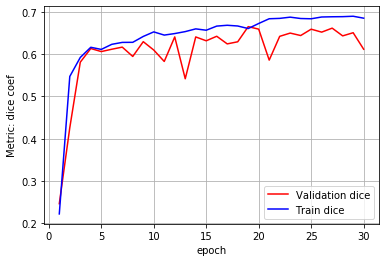

In [53]:
if train_segmentation == True:
    # TRAIN AND VALIDATE MODEL
    # Defect 1
    model.compile(optimizer='adam', loss=sm.losses.dice_loss,metrics=[dice_coef])
    train_batches = train_DataGenerator_3(train_data_1,shuffle=True,preprocess=preprocess)    
    valid_batches = test_DataGenerator_3(val_data_1,preprocess=preprocess)
    
    # https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
    logdir = "/content/drive/My Drive/severstal_february/severstal_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_1_01_02_2020'
    file_writer = tf.summary.FileWriter(logdir + "/metrics")
    tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
    
    # https://keras.io/callbacks/
    mc = ModelCheckpoint('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_1_01_02_2020.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
    #model training
    history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = epochs, verbose=1, callbacks = [mc,tensorboard])
    
    # plotting the metric
    vy = history.history['val_dice_coef']
    ty = history.history['dice_coef']
    x = list(range(1,len(vy)+1))
    fig,ax = plt.subplots(1,1)
    ax.plot(x,vy,'r',label = "Validation dice")
    ax.plot(x,ty,'b',label = "Train dice")
    ax.set_xlabel('epoch')
    ax.set_ylabel('Metric: dice coef')
    plt.legend()
    plt.grid()
    plt.show()
    file_writer.close()

<img src='./defect_1_tensorboard/train_dice.jpg' width=600px align = left>

<img src='./defect_1_tensorboard/val_dice.jpg' width=600px align = left>

**Summary:** Improvement of the Model performance at each epoch is smooth. It can also be observed that the model is not overfitting on the training set as the dice coefficien values on both the datasets are closer to each other and are improving simultaneously.

### Defect type 1: Evaluation

In [0]:
model = load_model('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_1_01_02_2020.h5', custom_objects=dependencies)

In [55]:
train_evaluate = model.evaluate(test_DataGenerator_3(train_data_1,preprocess=preprocess),verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef'])

645/645 [==============================] - 30s 46ms/step
Train set evaluation score:


dice_loss  0.285742
dice_coef  0.714258

In [56]:
validation_evaluate = model.evaluate(test_DataGenerator_3(val_data_1,preprocess=preprocess),verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

161/161 [==============================] - 6s 35ms/step
Validation set evaluation score:


dice_loss  0.334879
dice_coef  0.665121

In [57]:
test_evaluate = model.evaluate(test_DataGenerator_3(test_data_1,preprocess=preprocess),verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

91/91 [==============================] - 3s 35ms/step
Test set evaluation score:


dice_loss  0.388797
dice_coef  0.611203

**Summary:** The values of dice coefficient metric for Defect 1 train, test and validation images can be seen to be far from each other. <br>

**Dice loss = 1 - dice coefficient.**
The performance of the model on dice_coefficient needs improvement which can be achieved by further training the model to 100+ epochs.

**Note:** Dice coefficient is also known as F1_score.

10/10 [==============================] - 7s 703ms/step


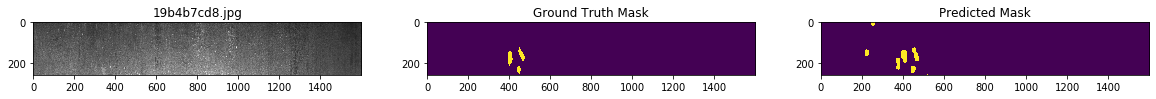

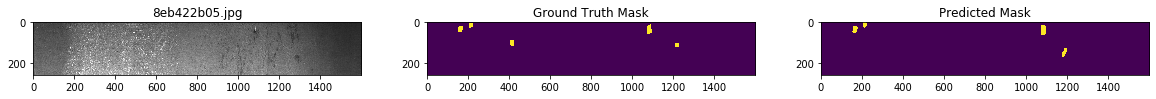

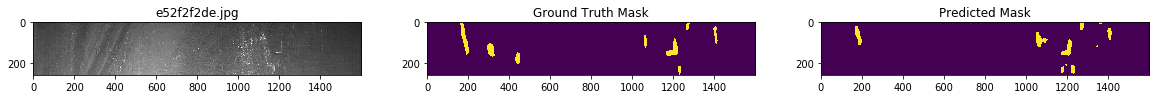

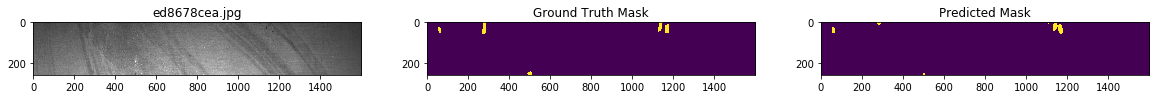

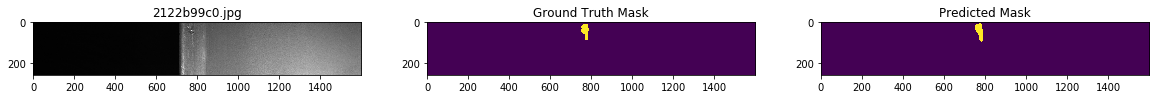

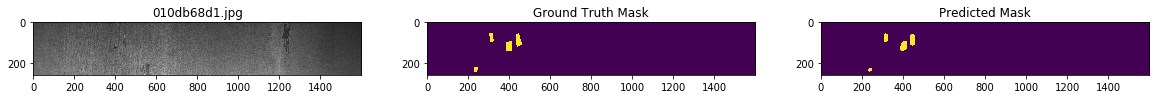

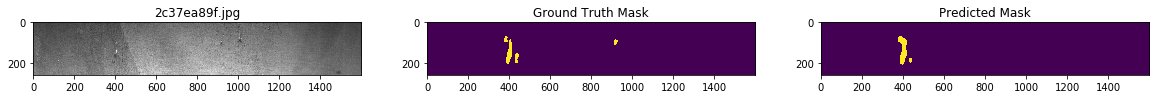

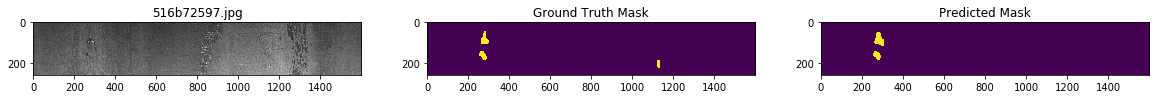

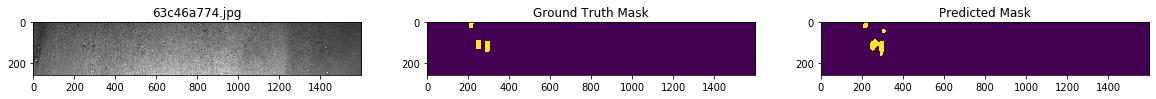

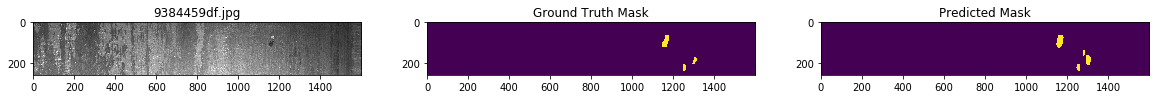

In [58]:
# Train dataset prediction visualization
train_preds = model.predict_generator(test_DataGenerator_3(train_data_1[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + train_data_1[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(train_data_1[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(train_data_1[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(train_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The above visualizations on training image dataset show how well the images are trained with supervised learning. The approximation in the predictions profile compered to true profile tells that the models can be further trained to identify the type 1 defects.

10/10 [==============================] - 0s 37ms/step


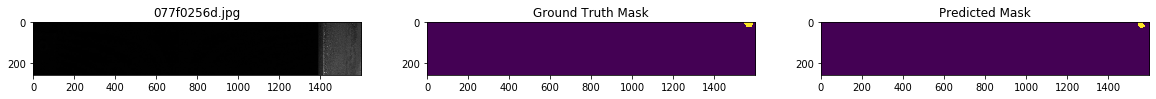

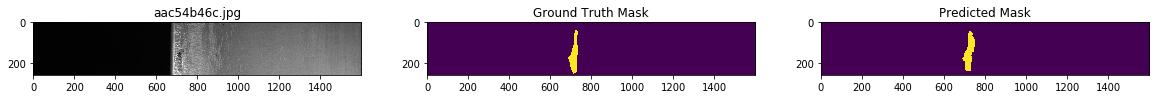

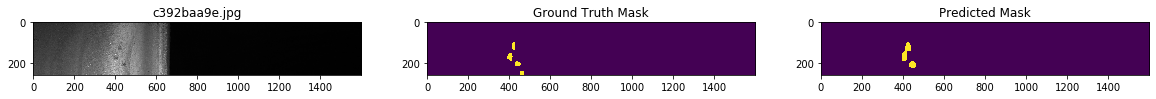

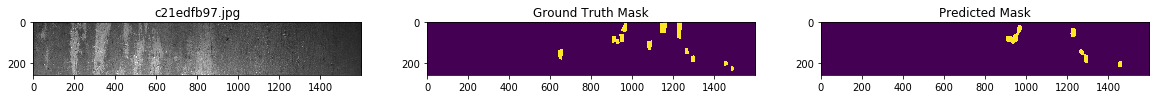

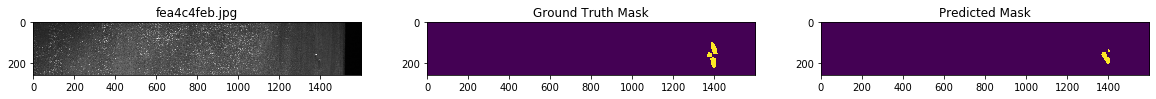

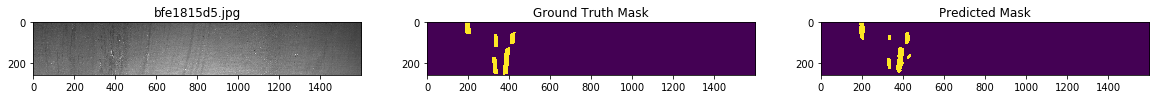

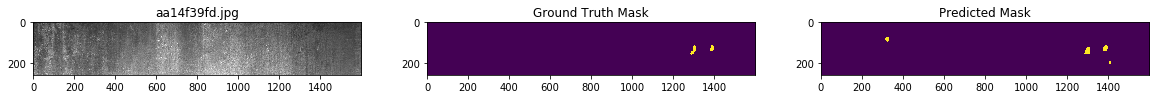

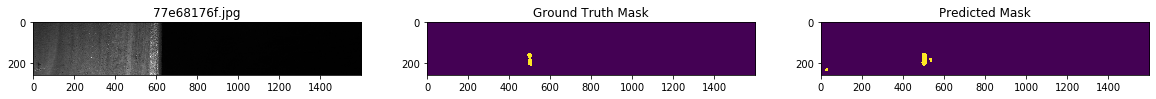

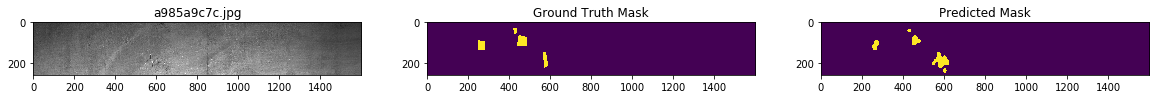

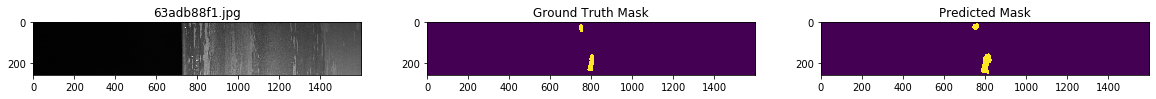

In [59]:
# Validation set
val_preds = model.predict_generator(test_DataGenerator_3(val_data_1[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + val_data_1[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(val_data_1[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(val_data_1[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(val_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The visualizations on validation dataset indicates that the model is performing well in identifying trained defect locations.

10/10 [==============================] - 0s 37ms/step


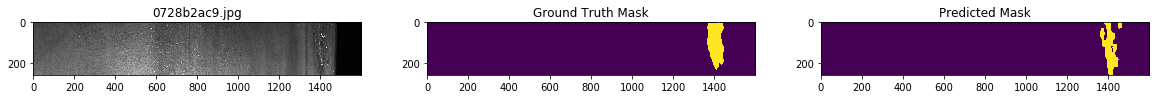

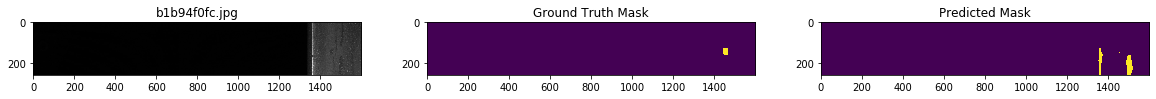

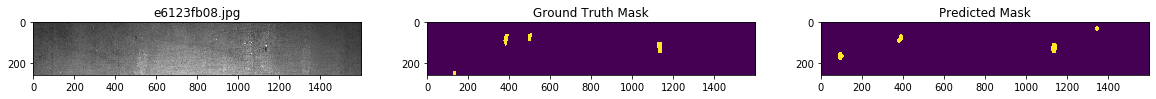

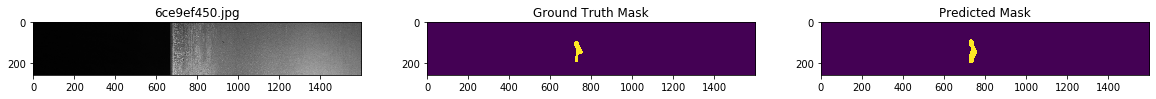

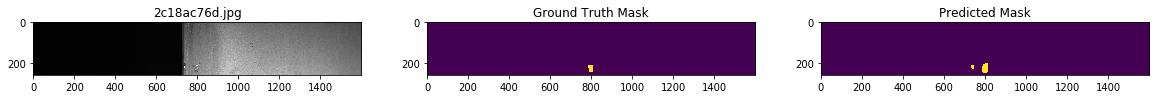

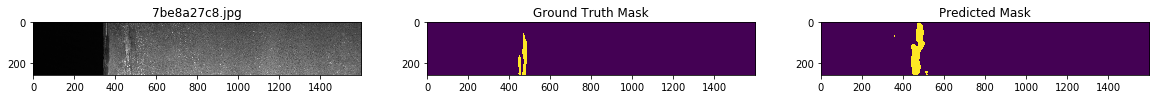

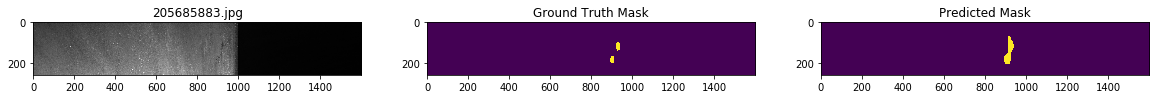

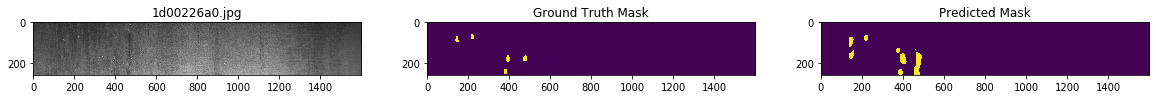

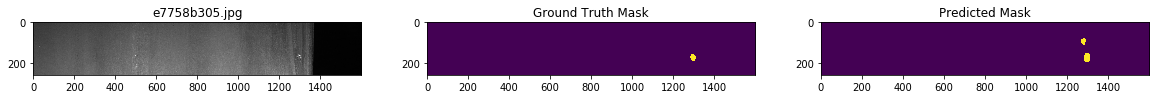

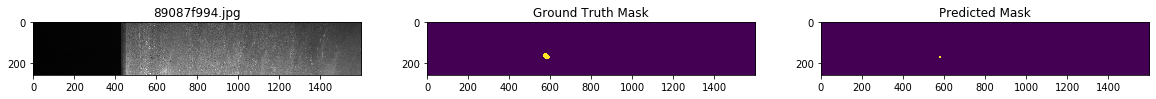

In [60]:
# Test set
test_preds = model.predict_generator(test_DataGenerator_3(test_data_1[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + test_data_1[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_1[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_1[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The above visualizations on test images tells us that the predicted locations of defect are similar to that of ground truth masks. The approximation in the predictions profile compered to true profile tells that the models can be further trained to identify the type 1 defects.

### II) Defect 2

Epoch 1/30
22/22 [==============================] - 37s 2s/step - loss: 0.5582 - dice_coef: 0.4418 - val_loss: 0.5546 - val_dice_coef: 0.4454

Epoch 00001: val_dice_coef improved from -inf to 0.44540, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_2_01_02_2020.h5
Epoch 2/30
22/22 [==============================] - 13s 599ms/step - loss: 0.4302 - dice_coef: 0.5698 - val_loss: 0.5052 - val_dice_coef: 0.4948

Epoch 00002: val_dice_coef improved from 0.44540 to 0.49482, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_2_01_02_2020.h5
Epoch 3/30
22/22 [==============================] - 13s 601ms/step - loss: 0.3847 - dice_coef: 0.6153 - val_loss: 0.4462 - val_dice_coef: 0.5538

Epoch 00003: val_dice_coef improved from 0.49482 to 0.55379, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_2_01_02_2020.h5
Epoch 4/30
22/22 [====

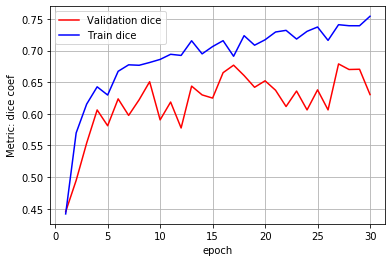

In [61]:
if train_segmentation == True:
    # TRAIN AND VALIDATE MODEL
    # Defect 2
    model.compile(optimizer='adam', loss=sm.losses.dice_loss,metrics=[dice_coef])
    train_batches = train_DataGenerator_3(train_data_2,shuffle=True,preprocess=preprocess)    
    valid_batches = test_DataGenerator_3(val_data_2,preprocess=preprocess)
    
    # https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
    logdir = "/content/drive/My Drive/severstal_february/severstal_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_2_01_02_2020'
    file_writer = tf.summary.FileWriter(logdir + "/metrics")
    tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
    
    # https://keras.io/callbacks/
    mc = ModelCheckpoint('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_2_01_02_2020.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
    #model training
    history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = epochs, verbose=1, callbacks = [mc,tensorboard])
    
    # plotting the metric
    vy = history.history['val_dice_coef']
    ty = history.history['dice_coef']
    x = list(range(1,len(vy)+1))
    fig,ax = plt.subplots(1,1)
    ax.plot(x,vy,'r',label = "Validation dice")
    ax.plot(x,ty,'b',label = "Train dice")
    ax.set_xlabel('epoch')
    ax.set_ylabel('Metric: dice coef')
    plt.legend()
    plt.grid()
    plt.show()
    file_writer.close()

**Summary:** Dice coefficient can be seen to get stabilised in 0.65-0.7 range on validation set Thus, to improve performance number of training images should be increased and other Nueral Network architectures are required to be explored.

### Defect type 2: Evaluation

In [0]:
model = load_model('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_2_01_02_2020.h5', custom_objects=dependencies)

In [63]:
train_evaluate = model.evaluate(test_DataGenerator_3(train_data_2,preprocess=preprocess),verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef'])

178/178 [==============================] - 16s 90ms/step
Train set evaluation score:


dice_loss  0.233052
dice_coef  0.766948

In [64]:
validation_evaluate = model.evaluate(test_DataGenerator_3(val_data_2,preprocess=preprocess),verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

44/44 [==============================] - 2s 37ms/step
Validation set evaluation score:


dice_loss  0.321188
dice_coef  0.678812

In [65]:
test_evaluate = model.evaluate(test_DataGenerator_3(test_data_2,preprocess=preprocess),verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

25/25 [==============================] - 1s 37ms/step
Test set evaluation score:


dice_loss  0.344606
dice_coef  0.655394

**Summary:** The dice coefficient of test set and validation set predictions can be seen to be closer to each other which imples that the model is generalizing well on unseen images. 

10/10 [==============================] - 9s 917ms/step


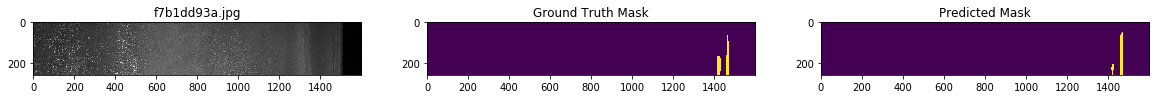

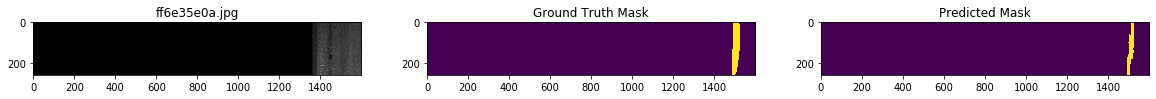

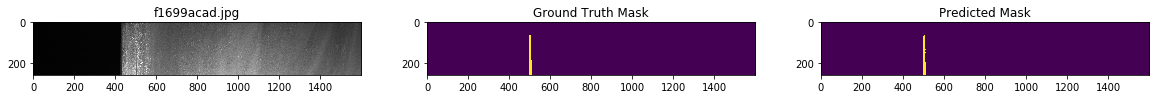

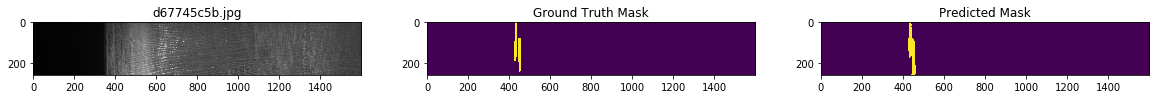

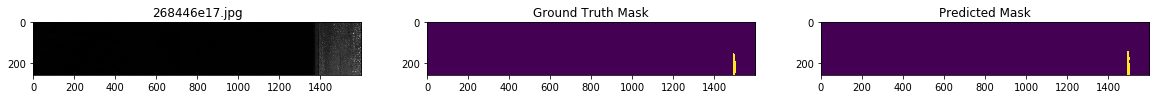

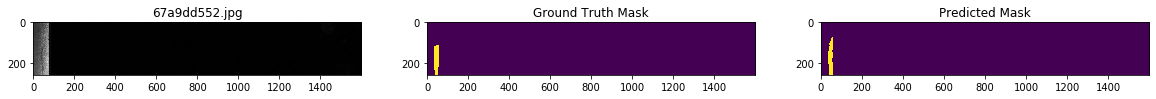

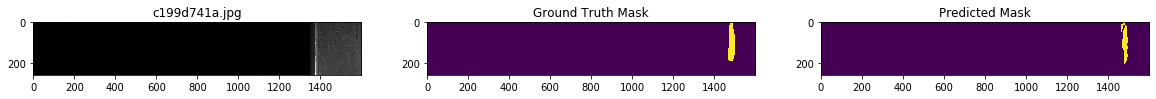

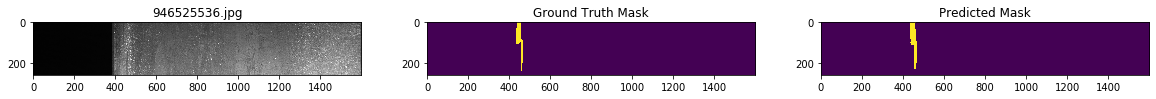

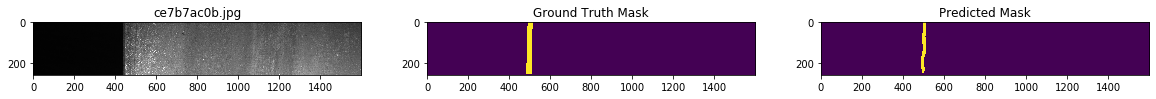

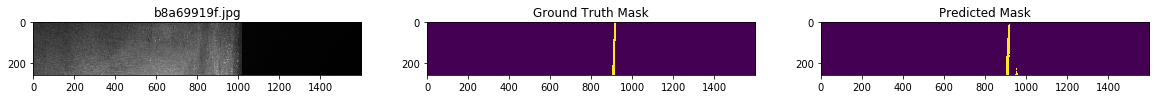

In [66]:
# Train dataset prediction visualization
train_preds = model.predict_generator(test_DataGenerator_3(train_data_2[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + train_data_2[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(train_data_2[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(train_data_2[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(train_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the training is satisfactory. The defect regional profiles can be seen to match in the training set.

10/10 [==============================] - 0s 37ms/step


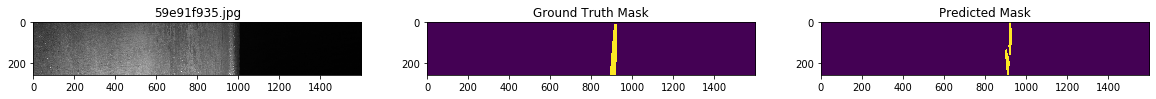

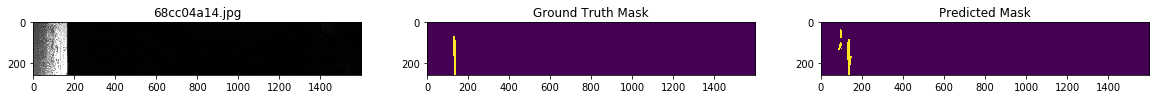

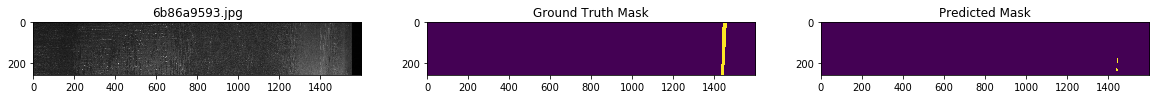

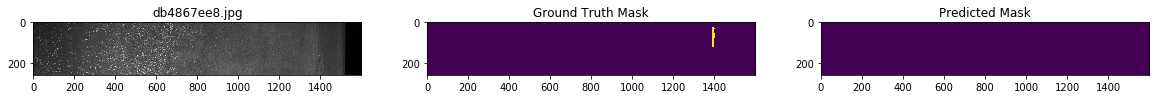

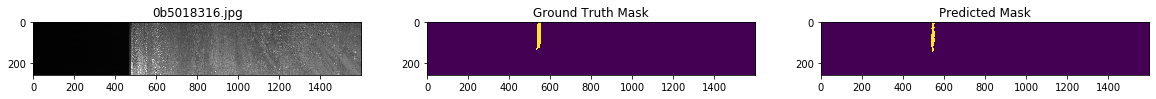

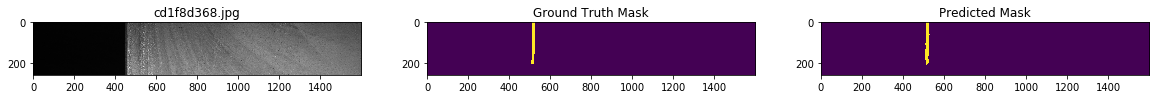

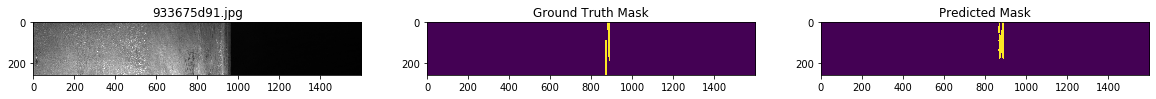

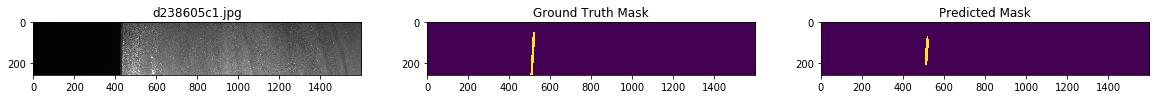

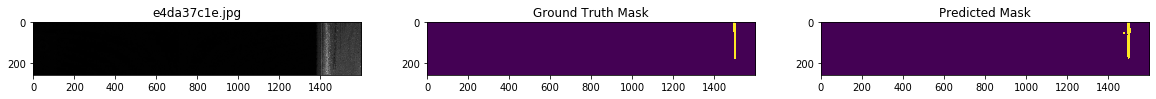

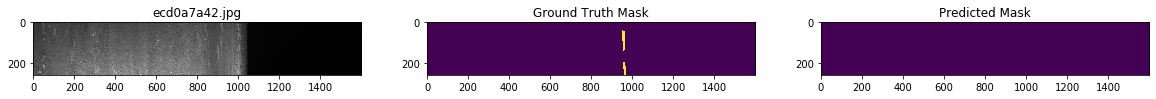

In [67]:
# Validation set
val_preds = model.predict_generator(test_DataGenerator_3(val_data_2[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + val_data_2[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(val_data_2[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(val_data_2[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(val_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the model predictability is satisfactory. The defect regional profiles can be seen to match in the validation set.

10/10 [==============================] - 0s 40ms/step


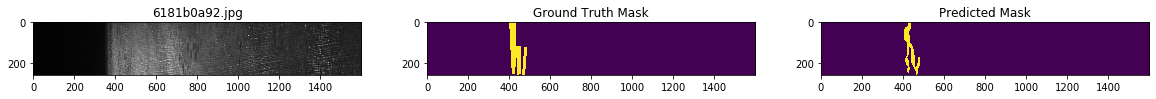

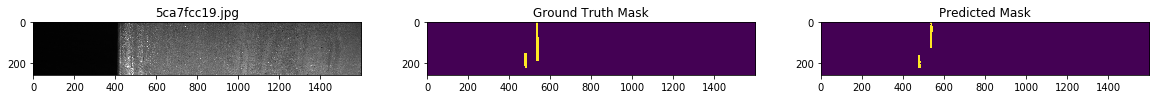

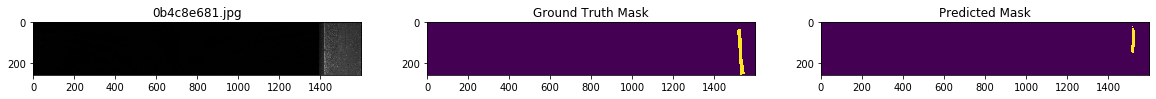

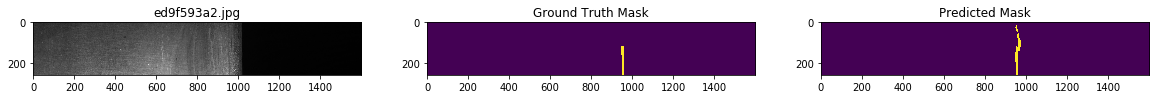

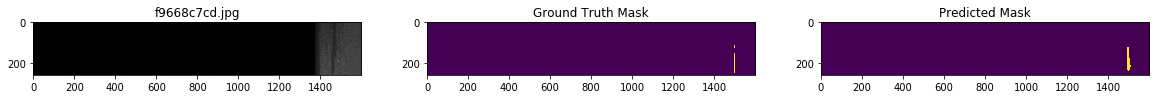

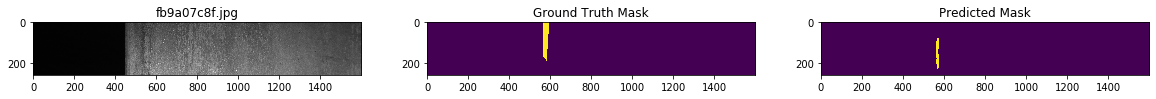

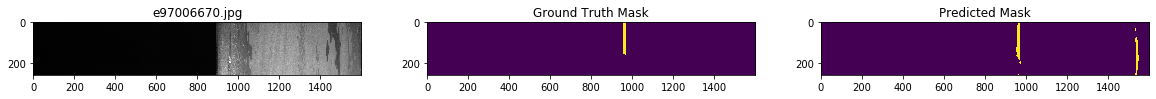

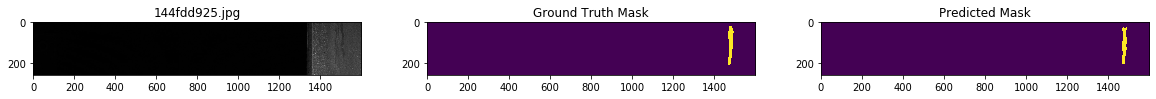

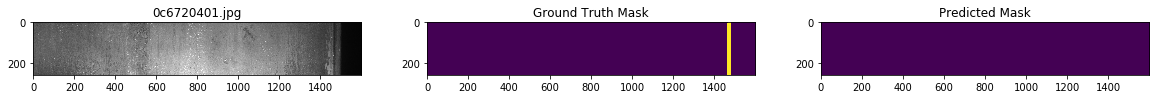

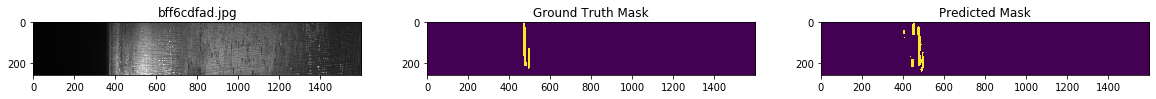

In [68]:
# Test set
test_preds = model.predict_generator(test_DataGenerator_3(test_data_2[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + test_data_2[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_2[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_2[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the model predictability is satisfactory. The defect regional profiles can be seen to match in the test set.

### III) Defect 3

Epoch 1/30
464/464 [==============================] - 305s 658ms/step - loss: 0.3954 - dice_coef: 0.6046 - val_loss: 0.3726 - val_dice_coef: 0.6274

Epoch 00001: val_dice_coef improved from -inf to 0.62736, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_3_01_02_2020.h5
Epoch 2/30
464/464 [==============================] - 278s 598ms/step - loss: 0.3398 - dice_coef: 0.6602 - val_loss: 0.3800 - val_dice_coef: 0.6200

Epoch 00002: val_dice_coef did not improve from 0.62736
Epoch 3/30
464/464 [==============================] - 277s 598ms/step - loss: 0.3318 - dice_coef: 0.6682 - val_loss: 0.3825 - val_dice_coef: 0.6175

Epoch 00003: val_dice_coef did not improve from 0.62736
Epoch 4/30
464/464 [==============================] - 278s 598ms/step - loss: 0.3166 - dice_coef: 0.6834 - val_loss: 0.3453 - val_dice_coef: 0.6547

Epoch 00004: val_dice_coef improved from 0.62736 to 0.65472, saving model to /content/drive/My Drive/severstal_fe

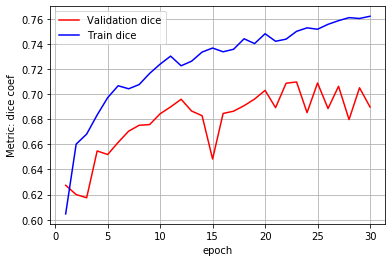

In [69]:
if train_segmentation == True:
    # TRAIN AND VALIDATE MODEL
    # Defect 3
    model.compile(optimizer='adam', loss=sm.losses.dice_loss,metrics=[dice_coef])
    train_batches = train_DataGenerator_3(train_data_3,shuffle=True,preprocess=preprocess)    
    valid_batches = test_DataGenerator_3(val_data_3,preprocess=preprocess)
    
    # https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
    logdir = "/content/drive/My Drive/severstal_february/severstal_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_3_01_02_2020'
    file_writer = tf.summary.FileWriter(logdir + "/metrics")
    tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
    
    # https://keras.io/callbacks/
    mc = ModelCheckpoint('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_3_01_02_2020.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
    #model training
    history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = epochs, verbose=1, callbacks = [mc,tensorboard])
    
    # plotting the metric
    vy = history.history['val_dice_coef']
    ty = history.history['dice_coef']
    x = list(range(1,len(vy)+1))
    fig,ax = plt.subplots(1,1)
    ax.plot(x,vy,'r',label = "Validation dice")
    ax.plot(x,ty,'b',label = "Train dice")
    ax.set_xlabel('epoch')
    ax.set_ylabel('Metric: dice coef')
    plt.legend()
    plt.grid()
    plt.show()
    file_writer.close()

**Summary:** The model performance got constrained near 0.72 dice coefficient level on defect type 3. To improve the performance training for 100 + epochs is required while the Neural Network architecture can also be experimented with.

### Defect type 3: Evaluation

In [0]:
model = load_model('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_3_01_02_2020.h5', custom_objects=dependencies)

In [71]:
train_evaluate = model.evaluate(test_DataGenerator_3(train_data_3,preprocess=preprocess),verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef'])

3712/3712 [==============================] - 181s 49ms/step
Train set evaluation score:


dice_loss  0.264481
dice_coef  0.735519

In [72]:
validation_evaluate = model.evaluate(test_DataGenerator_3(val_data_3,preprocess=preprocess),verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

914/914 [==============================] - 41s 45ms/step
Validation set evaluation score:


dice_loss  0.290359
dice_coef  0.709641

In [73]:
test_evaluate = model.evaluate(test_DataGenerator_3(test_data_3,preprocess=preprocess),verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

524/524 [==============================] - 24s 45ms/step
Test set evaluation score:


dice_loss  0.301452
dice_coef  0.698548

**Summary:** The dice coefficient of test set and validation set predictions can be seen to be closer to each other which imples that the model is generalizing well on unseen images. 

10/10 [==============================] - 12s 1s/step


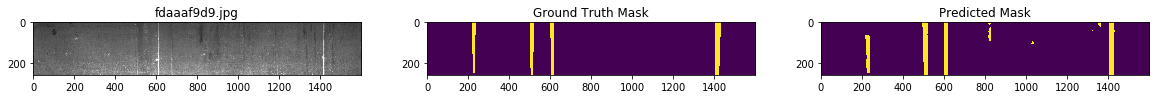

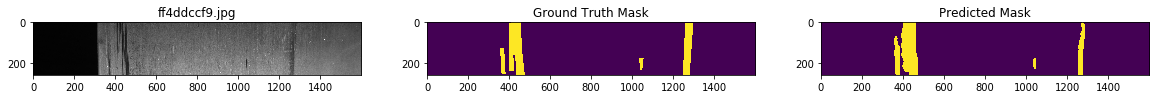

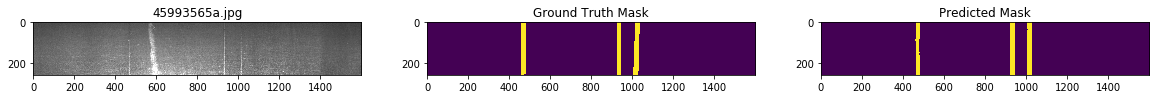

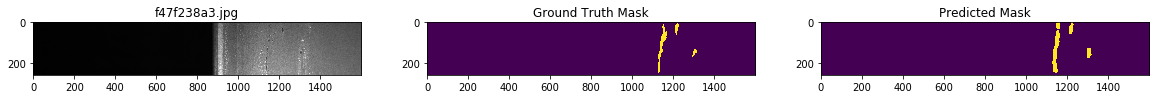

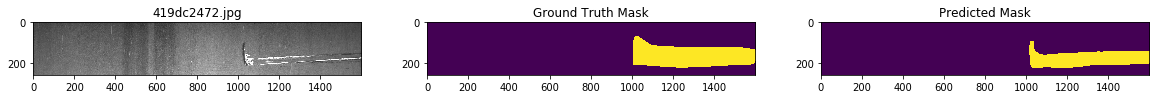

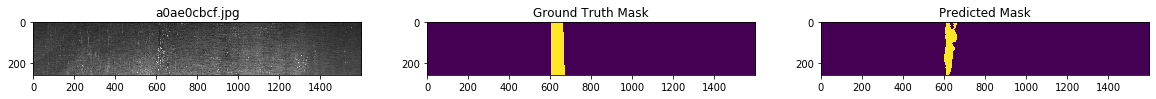

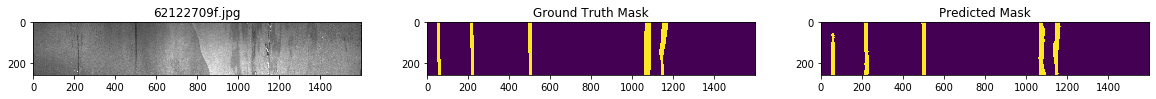

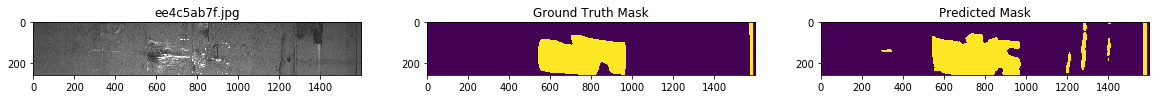

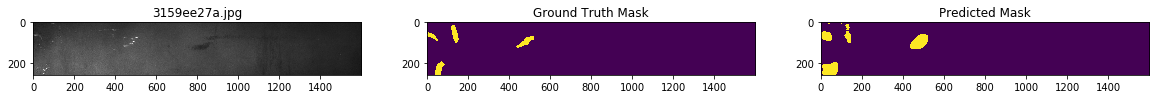

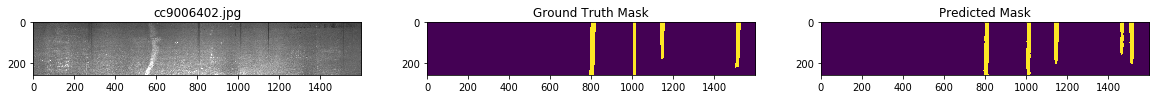

In [74]:
# Train dataset prediction visualization
train_preds = model.predict_generator(test_DataGenerator_3(train_data_3[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + train_data_3[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(train_data_3[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(train_data_3[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(train_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the training is satisfactory. The defect regional profiles can be seen to match in the training set.

10/10 [==============================] - 0s 45ms/step


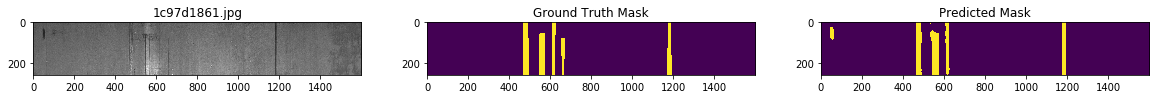

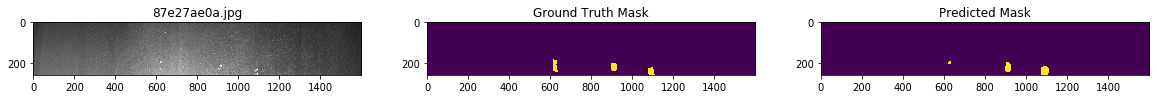

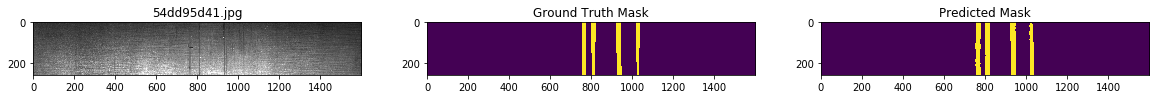

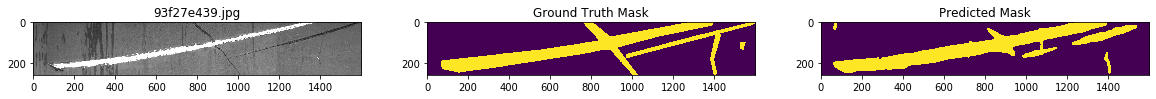

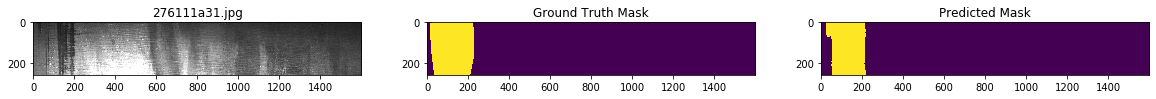

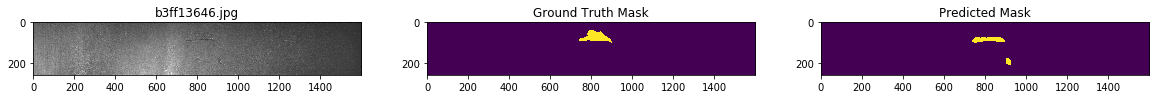

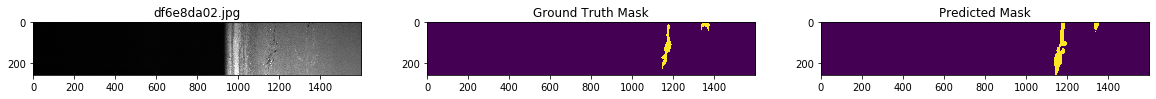

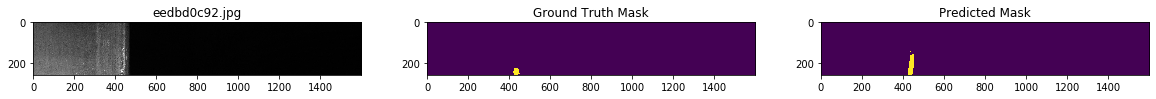

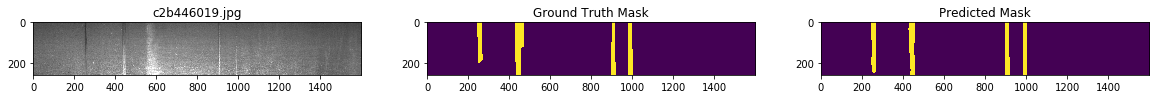

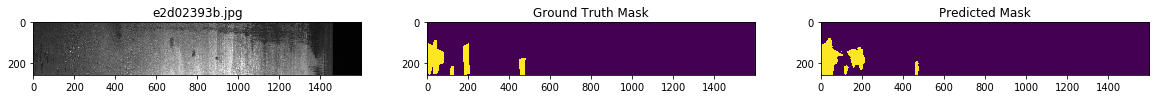

In [75]:
# Validation set
val_preds = model.predict_generator(test_DataGenerator_3(val_data_3[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + val_data_3[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(val_data_3[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(val_data_3[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(val_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the model predictability is satisfactory. The defect regional profiles can be seen to match in the validation set.

10/10 [==============================] - 0s 46ms/step


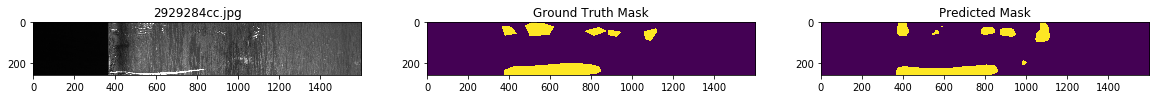

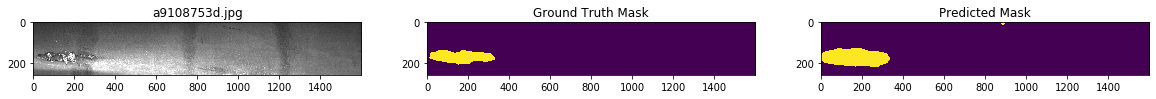

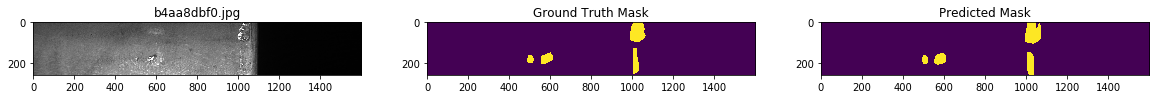

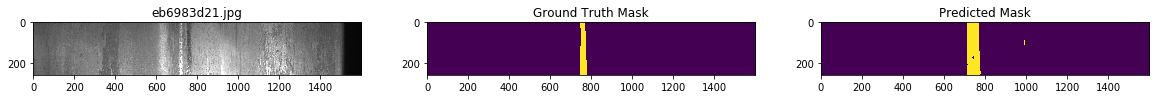

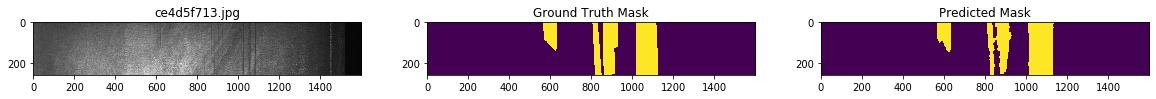

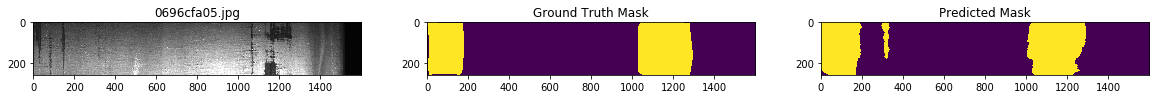

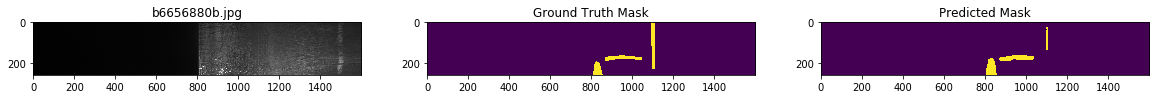

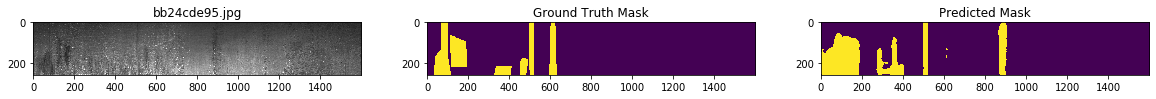

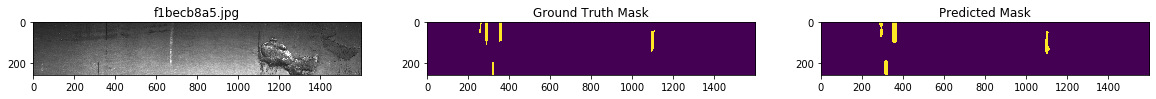

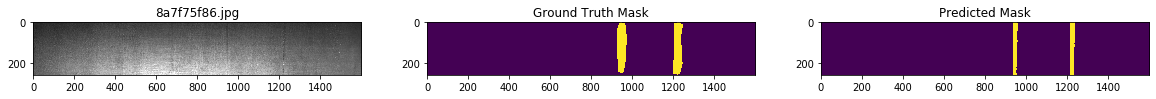

In [76]:
# Test set
test_preds = model.predict_generator(test_DataGenerator_3(test_data_3[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + test_data_3[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_3[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_3[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the model predictability is satisfactory. The defect regional profiles can be seen to match in the test set.

### IV) Defect 4

Epoch 1/30
72/72 [==============================] - 75s 1s/step - loss: 0.3560 - dice_coef: 0.6440 - val_loss: 0.3227 - val_dice_coef: 0.6773

Epoch 00001: val_dice_coef improved from -inf to 0.67726, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_4_01_02_2020.h5
Epoch 2/30
72/72 [==============================] - 46s 637ms/step - loss: 0.2668 - dice_coef: 0.7332 - val_loss: 0.2918 - val_dice_coef: 0.7082

Epoch 00002: val_dice_coef improved from 0.67726 to 0.70817, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_4_01_02_2020.h5
Epoch 3/30
72/72 [==============================] - 46s 638ms/step - loss: 0.2580 - dice_coef: 0.7420 - val_loss: 0.2808 - val_dice_coef: 0.7192

Epoch 00003: val_dice_coef improved from 0.70817 to 0.71920, saving model to /content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_4_01_02_2020.h5
Epoch 4/30
72/72 [====

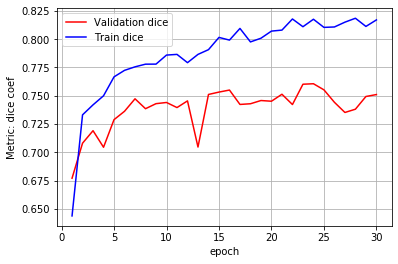

In [77]:
if train_segmentation == True:
    # TRAIN AND VALIDATE MODEL
    # Defect 4
    model.compile(optimizer='adam', loss=sm.losses.dice_loss,metrics=[dice_coef])
    train_batches = train_DataGenerator_3(train_data_4,shuffle=True,preprocess=preprocess)    
    valid_batches = test_DataGenerator_3(val_data_4,preprocess=preprocess)
    
    # https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
    logdir = "/content/drive/My Drive/severstal_february/severstal_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_Defect_4_01_02_2020'
    file_writer = tf.summary.FileWriter(logdir + "/metrics")
    tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
    
    # https://keras.io/callbacks/
    mc = ModelCheckpoint('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_4_01_02_2020.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
    #model training
    history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = epochs, verbose=1, callbacks = [mc,tensorboard])
    
    # plotting the metric
    vy = history.history['val_dice_coef']
    ty = history.history['dice_coef']
    x = list(range(1,len(vy)+1))
    fig,ax = plt.subplots(1,1)
    ax.plot(x,vy,'r',label = "Validation dice")
    ax.plot(x,ty,'b',label = "Train dice")
    ax.set_xlabel('epoch')
    ax.set_ylabel('Metric: dice coef')
    plt.legend()
    plt.grid()
    plt.show()
    file_writer.close()

<img src='./defect_4_tensorboard/train_dice.jpg' width=600px align = left>

<img src='./defect_4_tensorboard/val_dice.jpg' width=600px align = left>

**Summary:** The model performance got constrained near 0.78 dice coefficient level on defect type 4. To improve the performance training for 100 + epochs is required while the Neural Network architecture can also be experimented with.

### Defect type 4: Evaluation

In [0]:
model = load_model('/content/drive/My Drive/severstal_february/severstal_model/severstal_segmentation_Defect_4_01_02_2020.h5', custom_objects=dependencies)

In [79]:
train_evaluate = model.evaluate(test_DataGenerator_3(train_data_4,preprocess=preprocess),verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate, columns = [' '], index=['dice_loss','dice_coef'])

576/576 [==============================] - 43s 74ms/step
Train set evaluation score:


dice_loss  0.178057
dice_coef  0.821943

In [80]:
validation_evaluate = model.evaluate(test_DataGenerator_3(val_data_4,preprocess=preprocess),verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(validation_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

144/144 [==============================] - 7s 49ms/step
Validation set evaluation score:


dice_loss  0.23934
dice_coef  0.76066

In [81]:
test_evaluate = model.evaluate(test_DataGenerator_3(test_data_4,preprocess=preprocess),verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['dice_loss','dice_coef'])

81/81 [==============================] - 4s 48ms/step
Test set evaluation score:


dice_loss  0.21178
dice_coef  0.78822

**Summary:** The dice coefficient of test set and validation set predictions can be seen to be closer to each other which imples that the model is generalizing well on unseen images. 

10/10 [==============================] - 15s 2s/step


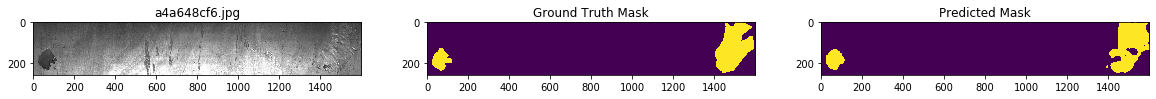

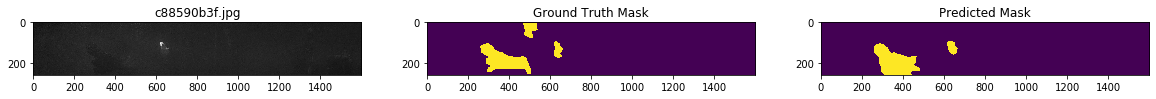

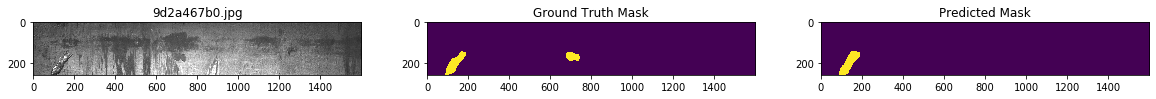

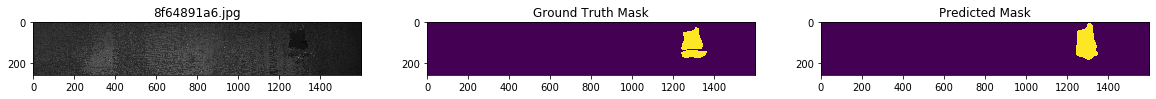

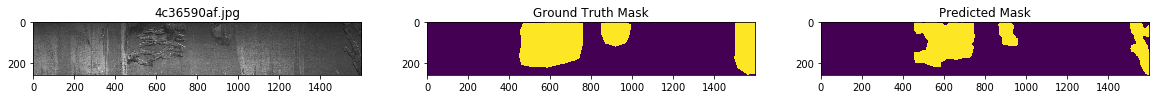

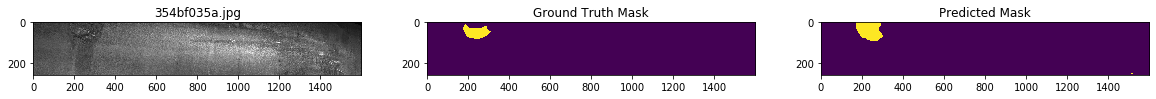

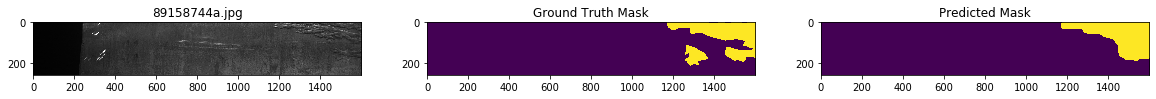

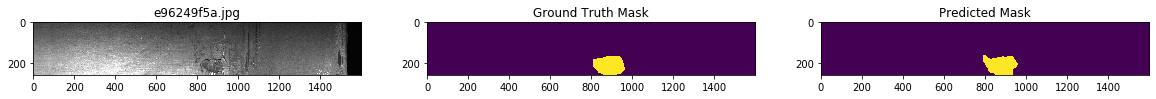

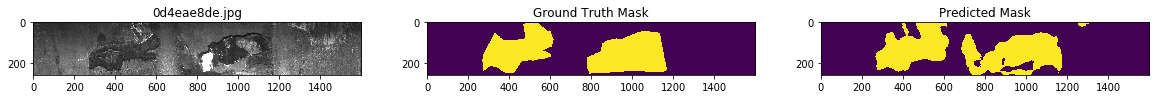

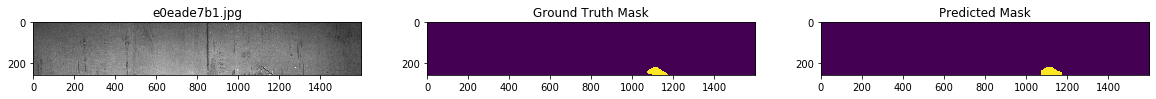

In [82]:
# Train dataset prediction visualization
train_preds = model.predict_generator(test_DataGenerator_3(train_data_4[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + train_data_4[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(train_data_4[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(train_data_4[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(train_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

10/10 [==============================] - 0s 49ms/step


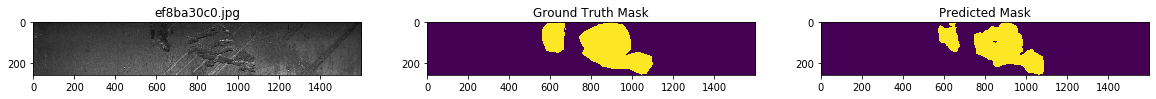

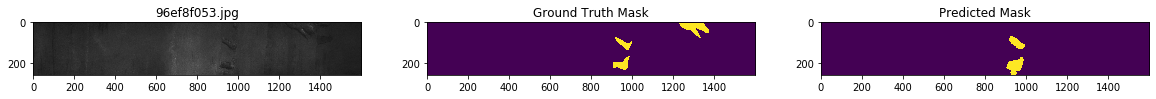

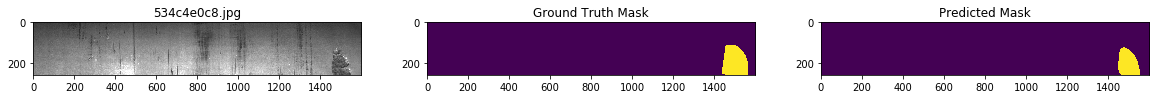

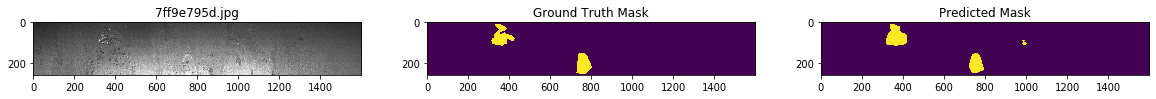

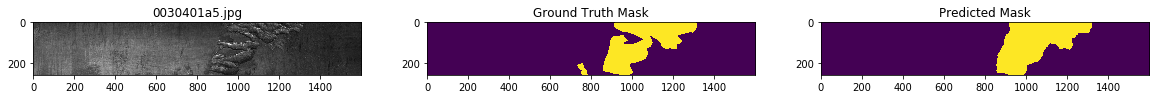

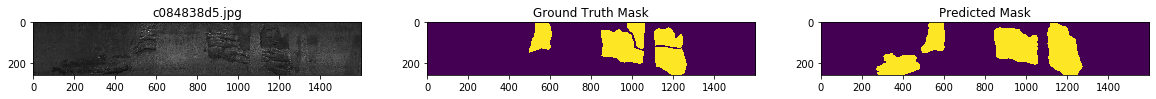

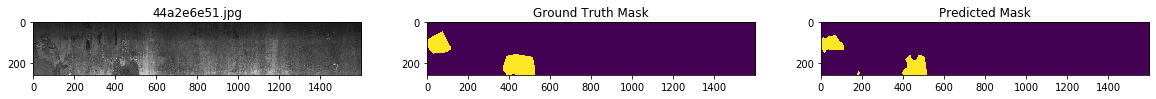

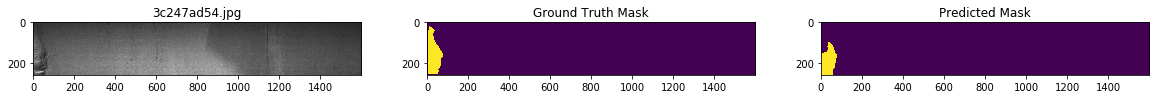

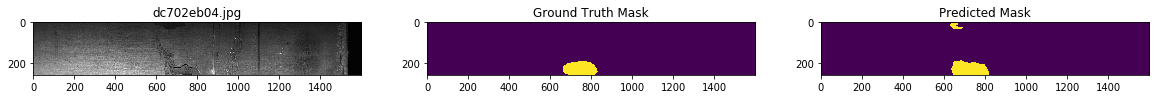

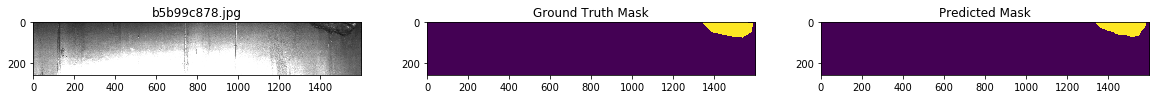

In [83]:
# Validation set
val_preds = model.predict_generator(test_DataGenerator_3(val_data_4[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + val_data_4[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(val_data_4[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(val_data_4[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(val_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the model predictability is satisfactory. The defect regional profiles can be seen to match in the validation set.

10/10 [==============================] - 0s 47ms/step


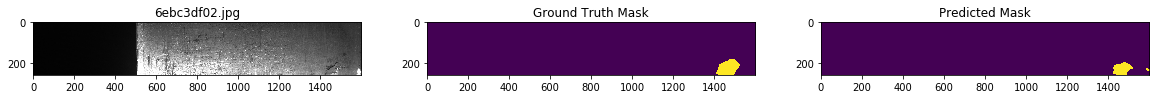

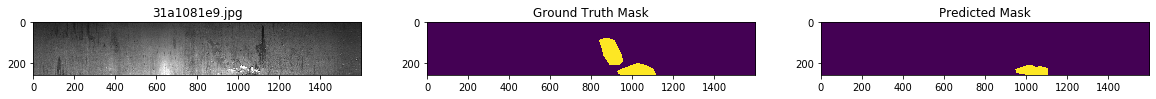

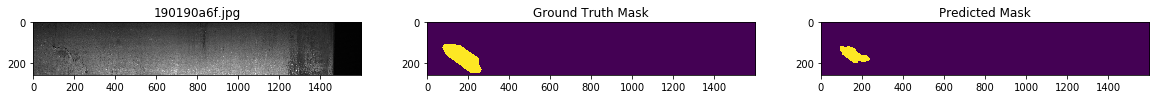

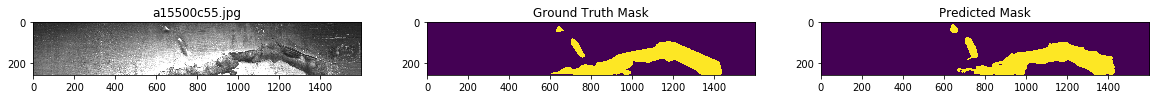

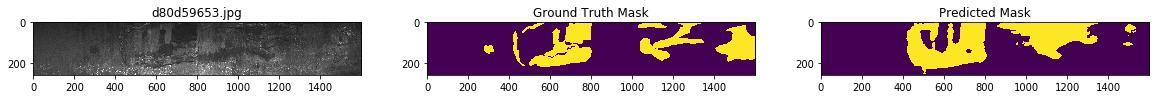

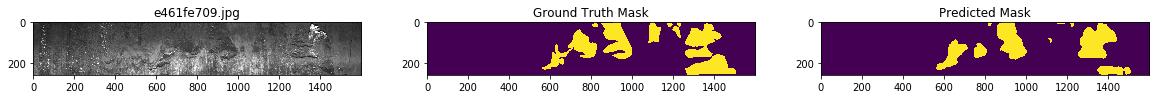

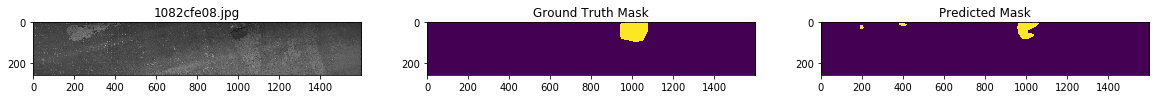

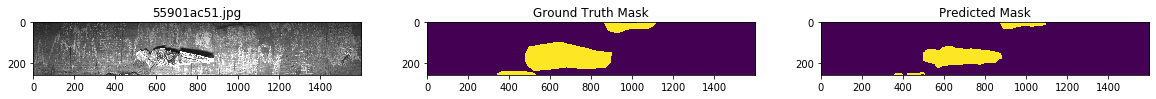

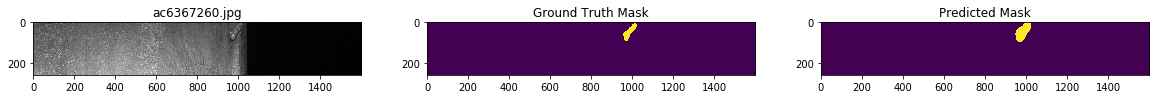

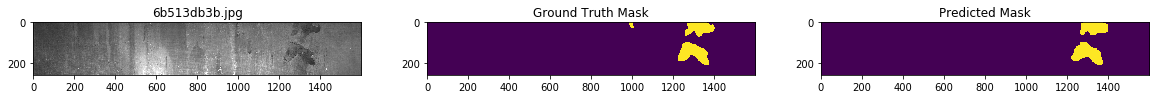

In [84]:
# Test set
test_preds = model.predict_generator(test_DataGenerator_3(test_data_4[10:20],preprocess=preprocess),verbose=1)
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))
    img = cv2.imread(str("/content/A1_train/" + test_data_4[10:20].ImageId.values[i]))
    ax1.imshow(img)
    ax1.set_title(test_data_4[10:20].ImageId.values[i])

    ax2.imshow(rle2mask(test_data_4[10:20].EncodedPixels.values[i]))
    ax2.set_title('Ground Truth Mask')

    c1 = Image.fromarray(test_preds[i][:,:,0])
    ax3.imshow(np.array(c1.resize((1600,256)))>0.5)
    ax3.set_title('Predicted Mask')
    plt.show()

**Summary:** The evaluation visualization indicates that the model predictability is satisfactory. The defect regional profiles can be seen to match in the test set.

In [1]:
# https://stackoverflow.com/questions/21892570/ipython-notebook-align-table-to-the-left-of-cell

%%html
<style>
table {float:left}
</style>


### Performance of the above trained models:

**Binary Classifier:** <br>

| Dataset | binary_crossentropy | acc | f1_score_m |precision_m | recall_m |
| :---: | :---: | :---: | :---: | :---: | :---: |
| X_train | 0.202241 | 0.923630 | 0.921999 | 0.949316 | 0.905966 |
| X_val | 0.240638 | 0.912064 | 0.912423 | 0.937087 | 0.898664 |
| X_test | 0.194755 | 0.926810 | 0.921435 | 0.955327 | 0.902135 |


**Multi Label Classifier:** <br>

| Dataset | binary_crossentropy | acc | f1_score_m |precision_m | recall_m |
| :---: | :---: | :---: | :---: | :---: | :---: |
| X_train | 0.081054 | 0.968118 | 0.940510 | 0.945815 | 0.937232 |
| X_val | 0.092119 | 0.962500| 0.929417 | 0.929264 | 0.931588 |
| X_test | 0.094178 |  0.965517 | 0.936398 | 0.941134 | 0.933854 |


**Segmentation models: Dice Coefficient:** <br>

| Dataset | Defect 1 model | Defect 2 model | Defect 3 model | Defect 4 model |
| :---: | :---: | :---: | :---: | :---: | :---: |
| X_train | 0.714258 | 0.766948 | 0.735519 | 0.821943 |
| X_val | 0.665121 | 0.678812 | 0.709641 | 0.76066 |
| X_test | 0.611203 | 0.655394 | 0.698548 | 0.78822 |
